In [1]:
!pip install numpy pandas scikit-learn tensorflow lxml matplotlib network

In [2]:
# -*- coding: utf-8 -*-
# Cell 1: Setup, Imports, Configuration, and Utilities

# --- Standard Libraries ---
import os
import gc
import time
import pickle
import json
import random
from collections import defaultdict
import xml.etree.ElementTree as ET # Fallback/Reference
from lxml import etree # Primary XML parser

# --- Data Handling & ML ---
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_recall_curve
import sklearn.metrics as m

# --- TensorFlow / Keras ---
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Lambda, Layer, Activation, Dot, Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping

print(f"TensorFlow Version: {tf.__version__}")
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

# ========================= Configuration Constants =========================
RAW_DATA_DIR = './raw_data'
PROCESSED_DATA_DIR = './data'
LOG_DIR = './log'
MODEL_SAVED_DIR = './ckpt'
DRUGBANK_XML_FILE = os.path.join(RAW_DATA_DIR, 'full database.xml') # Ensure this file exists in Colab
DATASET_NAME = 'drugbank'

# Ensure directories exist
os.makedirs(RAW_DATA_DIR, exist_ok=True)
os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(MODEL_SAVED_DIR, exist_ok=True)

# --- File Name Templates ---
# (Keep these consistent across cells)
DRUG_VOCAB_TEMPLATE = '{dataset}_drug_vocab.pkl'
ENTITY_VOCAB_TEMPLATE = '{dataset}_entity_vocab.pkl'
RELATION_VOCAB_TEMPLATE = '{dataset}_relation_vocab.pkl'
ADJ_ENTITY_TEMPLATE = '{dataset}_adj_entity.npy'
ADJ_RELATION_TEMPLATE = '{dataset}_adj_relation.npy'
KG_FILE_TEMPLATE = '{dataset}_train2id.txt'
EXAMPLE_FILE_TEMPLATE = '{dataset}_approved_example.txt' # Raw positive examples
FINAL_TRAIN_DATA_FILE = '{dataset}_final_train_data.npy' # Combined pos/neg samples
FINAL_VALID_DATA_FILE = '{dataset}_final_valid_data.npy'
FINAL_TEST_DATA_FILE = '{dataset}_final_test_data.npy'
ENTITY2ID_FILE_TEMPLATE = '{dataset}_entity2id.txt' # For reference
PERFORMANCE_LOG = 'kgcn_performance.log'
RESULT_LOG_TEMPLATE = '{dataset}_result.txt'

# ========================= Utility Functions =========================
def format_filename(_dir: str, filename_template: str, **kwargs):
    """Obtain the filename."""
    filename = os.path.join(_dir, filename_template.format(**kwargs))
    return filename

def pickle_load(filename: str):
    """Load object from pickle file."""
    try:
        with open(filename, 'rb') as f:
            obj = pickle.load(f)
        print(f'Logging Info - Loaded: {filename}')
        return obj
    except FileNotFoundError:
        print(f'Logging Error - File not found: {filename}')
        return None
    except EOFError:
        print(f'Logging Error - Cannot load (EOFError): {filename}')
        return None
    except Exception as e:
        print(f'Logging Error - General error loading {filename}: {e}')
        return None

def pickle_dump(filename: str, obj):
    """Save object to pickle file."""
    try:
        with open(filename, 'wb') as f:
            pickle.dump(obj, f)
        print(f'Logging Info - Saved: {filename}')
    except Exception as e:
        print(f'Logging Error - Failed to save {filename}: {e}')

def write_log(filename: str, log, mode='w'):
    """Write log data to a file."""
    try:
        with open(filename, mode) as writer:
            writer.write('\n')
            json.dump(log, writer, indent=4, ensure_ascii=False)
    except Exception as e:
        print(f"Error writing log to {filename}: {e}")

def get_optimizer(op_type, learning_rate):
    """Get Keras optimizer instance."""
    if op_type == 'sgd':
        return optimizers.SGD(learning_rate)
    elif op_type == 'rmsprop':
        return optimizers.RMSprop(learning_rate)
    elif op_type == 'adagrad':
        return optimizers.Adagrad(learning_rate)
    elif op_type == 'adadelta':
        return optimizers.Adadelta(learning_rate)
    elif op_type == 'adam':
        return optimizers.Adam(learning_rate, clipnorm=5)
    else:
        raise ValueError('Optimizer Not Understood: {}'.format(op_type))

print("Cell 1: Setup Complete.")

TensorFlow Version: 2.18.0
Num GPUs Available: 1
Cell 1: Setup Complete.


In [7]:
# Cell 2: XML Parsing and Initial Data Formatting (Corrected iterparse call)

# ========================= XML Parsing Function (lxml) =========================
def parse_drugbank_xml_lxml(xml_file):
    """Parses DrugBank XML using lxml.etree.iterparse."""
    print(f"Parsing DrugBank XML using lxml: {xml_file}...")
    if not os.path.exists(xml_file):
        raise FileNotFoundError(f"XML file not found: {xml_file}")

    drugs = {}
    entities = {}
    relations = set()
    ddi_interactions = set()

    # Define context with recovery mode and encoding directly in iterparse
    # REMOVED: parser = etree.XMLParser(recover=True, encoding='utf-8')
    try:
        context = etree.iterparse(xml_file,
                                  events=('end',),
                                  tag='{http://www.drugbank.ca}drug',
                                  recover=True, # Pass recover flag directly
                                  encoding='utf-8') # Specify encoding
    except Exception as e:
        print(f"Error initializing iterparse: {e}")
        return None, None, None, None, None # Return None to indicate failure

    start_time = time.time()
    drug_count = 0
    ns_map = {'db': 'http://www.drugbank.ca'}
    relation_map = {
        'targets': 'targets', 'enzymes': 'enzyme_interaction',
        'transporters': 'transporter_interaction', 'carriers': 'carrier_interaction',
        'ddi': 'interacts_with'
    }
    all_relation_types = set(relation_map.values())

    parsing_errors = 0
    for event, drug_elem in context:
        drug_count += 1
        if drug_count % 1000 == 0: print(f"  Processed {drug_count} drugs...")

        try:
            primary_id_elem = drug_elem.xpath('./db:drugbank-id[@primary="true"]/text()', namespaces=ns_map)
            primary_id = primary_id_elem[0] if primary_id_elem else None
            if not primary_id:
                # Cleanup handled in finally block
                continue # Skip if no primary ID

            name_elem = drug_elem.xpath('./db:name/text()', namespaces=ns_map)
            name = name_elem[0] if name_elem else f"Unknown_{primary_id}"
            drugs[primary_id] = name
            entities[primary_id] = {'name': name, 'type': 'drug'}

            # Extract Relations
            for rel_tag in ['targets', 'enzymes', 'transporters', 'carriers']:
                # Corrected XPath to handle potential nesting if needed (e.g., within <target>)
                entity_elements = drug_elem.xpath(f'./db:{rel_tag}/db:{rel_tag[:-1]}', namespaces=ns_map)
                for entity_elem in entity_elements:
                    # Prioritize polypeptide-id if it exists, otherwise use generic id
                    target_id_elems = entity_elem.xpath('.//db:polypeptide-id/text() | .//db:id/text()', namespaces=ns_map)
                    target_id = target_id_elems[0] if target_id_elems else None
                    if target_id:
                        target_name_elems = entity_elem.xpath('.//db:name/text()', namespaces=ns_map)
                        target_name = target_name_elems[0] if target_name_elems else f"Unknown_{target_id}"
                        entity_type = 'protein'
                        if target_id not in entities:
                            entities[target_id] = {'name': target_name, 'type': entity_type}
                        relations.add((primary_id, relation_map[rel_tag], target_id))
                        all_relation_types.add(relation_map[rel_tag])

            # Extract DDIs
            interaction_elements = drug_elem.xpath('./db:drug-interactions/db:drug-interaction', namespaces=ns_map)
            for interaction_elem in interaction_elements:
                interactor_id_elem = interaction_elem.xpath('./db:drugbank-id/text()', namespaces=ns_map)
                interactor_id = interactor_id_elem[0] if interactor_id_elem else None
                if interactor_id:
                    pair = tuple(sorted((primary_id, interactor_id)))
                    ddi_interactions.add(pair)
                    relations.add((primary_id, relation_map['ddi'], interactor_id))
                    all_relation_types.add(relation_map['ddi'])

        except Exception as e:
             parsing_errors += 1
             if parsing_errors < 20: # Report first few errors
                 print(f"Error processing drug element near count {drug_count}: {e}")
             elif parsing_errors == 20:
                 print("...(suppressing further parsing errors)...")
             # Recovery mode should allow continuing, but log the issue
        finally:
            # Memory cleanup is crucial for iterparse
            if drug_elem is not None:
                 drug_elem.clear()
                 # Clear previous siblings efficiently
                 parent = drug_elem.getparent()
                 if parent is not None:
                     while drug_elem.getprevious() is not None:
                         del parent[0]


    end_time = time.time()
    print(f"Finished parsing {drug_count} drug elements in {end_time - start_time:.2f} seconds.")
    if parsing_errors > 0:
        print(f"Encountered {parsing_errors} errors during element processing (recovery attempted).")

    # --- Post-process and Validate ---
    # (Keep this part the same as before)
    valid_ddi_interactions = set()
    valid_relations = set()
    known_drug_ids = set(drugs.keys())

    print("Validating relations and DDI pairs...")
    for h, r, t in relations:
        if h in entities and t in entities and r in relation_map.values(): # Ensure relation type is known
            valid_relations.add((h, r, t))

    for d1, d2 in ddi_interactions:
        if d1 in known_drug_ids and d2 in known_drug_ids:
            valid_ddi_interactions.add((d1, d2))

    print(f"Found {len(drugs)} drugs, {len(entities)} total entities.")
    print(f"Found {len(valid_ddi_interactions)} unique known DDI pairs.")
    print(f"Found {len(valid_relations)} valid relation triples.")

    return drugs, entities, valid_relations, valid_ddi_interactions, list(all_relation_types)


# ========================= Data Formatting Function =========================
# (Keep this function exactly the same as before)
def format_and_save_data(drugs, entities, relations, ddi_interactions, all_relation_types, dataset_name):
    """Formats extracted data and saves to files."""
    print("Formatting and saving data...")
    # Create Vocabs
    # Check if inputs are valid before proceeding
    if not drugs or not entities:
        print("Error: Empty drugs or entities dictionary passed to format_and_save_data.")
        return None, None, None, None, None

    drug_vocab = {name: i for i, name in enumerate(drugs.keys())}
    # Ensure entities dict is not empty before getting keys
    entity_vocab = {name: i for i, name in enumerate(entities.keys())} if entities else {}
    # Ensure relation types list is not empty
    relation_vocab = {name: i for i, name in enumerate(sorted(all_relation_types))} if all_relation_types else {}

    # Check if vocabs were created
    if not drug_vocab or not entity_vocab or not relation_vocab:
         print("Error: Failed to create one or more vocabularies (drugs/entities/relations might be empty).")
         # Decide how to handle - return None or empty structures
         return None, None, None, None, None


    # Save entity2id file
    entity2id_filepath = format_filename(PROCESSED_DATA_DIR, ENTITY2ID_FILE_TEMPLATE, dataset=dataset_name)
    with open(entity2id_filepath, 'w', encoding='utf8') as f_ent:
        f_ent.write(f"{len(drugs)}\n")
        for drug_id_str, _ in drugs.items():
            if drug_id_str in entity_vocab:
                f_ent.write(f"{drug_id_str}\t{entity_vocab[drug_id_str]}\n")
            else:
                print(f"Warning: Drug ID {drug_id_str} not found in final entity_vocab during entity2id save.")
    print(f"Saved entity2id reference file to: {entity2id_filepath}")

    # Save KG triples
    kg_filepath = format_filename(PROCESSED_DATA_DIR, KG_FILE_TEMPLATE, dataset=dataset_name)
    kg_triples_idx = []
    valid_triple_count = 0
    with open(kg_filepath, 'w', encoding='utf8') as f_kg:
        f_kg.write("COUNT_PLACEHOLDER\n")
        for h, r, t in relations:
            # Double check existence in vocabs
            if h in entity_vocab and r in relation_vocab and t in entity_vocab:
                head_idx = entity_vocab[h]
                rel_idx = relation_vocab[r]
                tail_idx = entity_vocab[t]
                f_kg.write(f"{head_idx} {tail_idx} {rel_idx}\n")
                kg_triples_idx.append((head_idx, tail_idx, rel_idx))
                valid_triple_count += 1
            else:
                # This shouldn't happen often if validation in parse function works
                 print(f"Warning: Skipping triple due to missing vocab entry during save: {h}, {r}, {t}")

    # Update count only if triples were written
    if valid_triple_count > 0:
        try:
            with open(kg_filepath, 'r+', encoding='utf8') as f_kg:
                content = f_kg.read()
                f_kg.seek(0, 0)
                f_kg.write(content.replace("COUNT_PLACEHOLDER", str(valid_triple_count), 1))
        except Exception as e:
            print(f"Error updating triple count in {kg_filepath}: {e}")
    else:
        # If no triples, overwrite placeholder with 0
        try:
            with open(kg_filepath, 'w', encoding='utf8') as f_kg: # Overwrite
                f_kg.write("0\n")
        except Exception as e:
             print(f"Error writing 0 count to {kg_filepath}: {e}")

    print(f"Saved {valid_triple_count} KG triples to {kg_filepath}")


    # Save POSITIVE DDI examples
    example_filepath = format_filename(PROCESSED_DATA_DIR, EXAMPLE_FILE_TEMPLATE, dataset=dataset_name)
    ddi_examples_pos = []
    with open(example_filepath, 'w', encoding='utf8') as f_ex:
        for d1, d2 in ddi_interactions:
            # Double check existence in drug_vocab
            if d1 in drug_vocab and d2 in drug_vocab:
                idx1 = drug_vocab[d1]
                idx2 = drug_vocab[d2]
                f_ex.write(f"{idx1}\t{idx2}\t1\n")
                ddi_examples_pos.append([idx1, idx2, 1])
            else:
                 print(f"Warning: Skipping DDI pair save due to missing drug vocab entry: {d1}, {d2}")

    print(f"Saved {len(ddi_examples_pos)} positive DDI examples to {example_filepath}")


    # Save Vocabularies
    pickle_dump(format_filename(PROCESSED_DATA_DIR, DRUG_VOCAB_TEMPLATE, dataset=dataset_name), drug_vocab)
    pickle_dump(format_filename(PROCESSED_DATA_DIR, ENTITY_VOCAB_TEMPLATE, dataset=dataset_name), entity_vocab)
    pickle_dump(format_filename(PROCESSED_DATA_DIR, RELATION_VOCAB_TEMPLATE, dataset=dataset_name), relation_vocab)

    # Return numpy array for positive examples
    return drug_vocab, entity_vocab, relation_vocab, kg_triples_idx, np.array(ddi_examples_pos) if ddi_examples_pos else np.empty((0,3), dtype=int)


# ========================= Execution =========================
# (Keep this part the same as before)
OVERWRITE_PREPROCESSING_STEP1 = True
drug_vocab_path = format_filename(PROCESSED_DATA_DIR, DRUG_VOCAB_TEMPLATE, dataset=DATASET_NAME)
run_parsing = OVERWRITE_PREPROCESSING_STEP1 or not os.path.exists(drug_vocab_path)

if run_parsing:
    print("\n--- Running Step 1 & 2: XML Parsing and Data Formatting ---")
    try:
        if not os.path.exists(DRUGBANK_XML_FILE):
             print(f"ERROR: Input XML file not found at {DRUGBANK_XML_FILE}")
             raise FileNotFoundError("Input XML missing")
        else:
            parsed_data = parse_drugbank_xml_lxml(DRUGBANK_XML_FILE)
            if parsed_data[0] is not None: # Check if parsing succeeded
                 drugs, entities, relations, ddi_interactions, rel_types = parsed_data
                 # Check if essential data structures are non-empty before formatting
                 if drugs and entities:
                     format_and_save_data(
                         drugs, entities, relations, ddi_interactions, rel_types, DATASET_NAME
                     )
                     print("--- Step 1 & 2 Complete ---")
                 else:
                     print("Error: Parsing resulted in empty drugs or entities. Formatting aborted.")
            else:
                 print("Error: XML Parsing failed. Cannot proceed.")

    except FileNotFoundError:
        pass # Error already printed
    except Exception as e:
        print(f"An error occurred during preprocessing Step 1 & 2: {e}")
        import traceback
        traceback.print_exc()
else:
    print("\n--- Skipping Step 1 & 2: Preprocessed files likely exist ---")

print("Cell 2: Processing Complete.")


--- Running Step 1 & 2: XML Parsing and Data Formatting ---
Parsing DrugBank XML using lxml: ./raw_data/full database.xml...
  Processed 1000 drugs...
  Processed 2000 drugs...
  Processed 3000 drugs...
  Processed 4000 drugs...
  Processed 5000 drugs...
  Processed 6000 drugs...
  Processed 7000 drugs...
  Processed 8000 drugs...
  Processed 9000 drugs...
  Processed 10000 drugs...
  Processed 11000 drugs...
  Processed 12000 drugs...
  Processed 13000 drugs...
  Processed 14000 drugs...
  Processed 15000 drugs...
  Processed 16000 drugs...
  Processed 17000 drugs...
  Processed 18000 drugs...
Finished parsing 18170 drug elements in 8.64 seconds.
Validating relations and DDI pairs...
Found 306 drugs, 1546 total entities.
Found 7863 unique known DDI pairs.
Found 18228 valid relation triples.
Formatting and saving data...
Saved entity2id reference file to: ./data/drugbank_entity2id.txt
Saved 18228 KG triples to ./data/drugbank_train2id.txt
Saved 7863 positive DDI examples to ./data/dru

In [8]:
# Cell 3: Negative Sampling and Data Splitting

# ========================= Negative Sampling Function =========================
def generate_negative_samples(positive_samples, drug_vocab_size, num_negative_ratio=1):
    """Generates negative DDI samples."""
    print("Generating negative DDI samples...")
    if positive_samples.shape[0] == 0:
        print("Warning: No positive samples provided.")
        return np.array([])

    pos_pairs = set(tuple(sorted((r[0], r[1]))) for r in positive_samples)
    num_neg_samples_to_gen = positive_samples.shape[0] * num_negative_ratio
    neg_samples = []
    max_attempts = num_neg_samples_to_gen * 100
    attempts = 0

    while len(neg_samples) < num_neg_samples_to_gen and attempts < max_attempts:
        attempts += 1
        d1_idx = random.randint(0, drug_vocab_size - 1)
        d2_idx = random.randint(0, drug_vocab_size - 1)
        if d1_idx == d2_idx: continue
        pair = tuple(sorted((d1_idx, d2_idx)))
        if pair not in pos_pairs:
            neg_samples.append([d1_idx, d2_idx, 0])
            pos_pairs.add(pair) # Avoid resampling this negative pair

    if attempts >= max_attempts:
        print(f"Warning: Reached max attempts for negative sampling. Generated {len(neg_samples)} samples.")
    print(f"Generated {len(neg_samples)} negative samples.")
    return np.array(neg_samples)

# ========================= Execution =========================
OVERWRITE_PREPROCESSING_STEP2 = True # Set to False to skip if final files exist

final_train_path = format_filename(PROCESSED_DATA_DIR, FINAL_TRAIN_DATA_FILE, dataset=DATASET_NAME)
final_valid_path = format_filename(PROCESSED_DATA_DIR, FINAL_VALID_DATA_FILE, dataset=DATASET_NAME)
final_test_path = format_filename(PROCESSED_DATA_DIR, FINAL_TEST_DATA_FILE, dataset=DATASET_NAME)

run_sampling_split = OVERWRITE_PREPROCESSING_STEP2 or not all(os.path.exists(p) for p in [final_train_path, final_valid_path, final_test_path])

if run_sampling_split:
    print("\n--- Running Step 2b: Negative Sampling and Data Splitting ---")
    # Load positive examples and drug vocab
    pos_example_path = format_filename(PROCESSED_DATA_DIR, EXAMPLE_FILE_TEMPLATE, dataset=DATASET_NAME)
    drug_vocab_path = format_filename(PROCESSED_DATA_DIR, DRUG_VOCAB_TEMPLATE, dataset=DATASET_NAME)

    drug_vocab = pickle_load(drug_vocab_path)
    try:
        ddi_examples_pos = np.loadtxt(pos_example_path, dtype=np.int64, delimiter='\t')
        if len(ddi_examples_pos.shape) == 1: ddi_examples_pos = ddi_examples_pos.reshape(1, -1)
    except Exception as e:
        print(f"Error loading positive examples from {pos_example_path}: {e}")
        ddi_examples_pos = None # Indicate error

    if drug_vocab is None or ddi_examples_pos is None:
        print("Error: Cannot perform negative sampling. Missing drug vocab or positive examples.")
    else:
        ddi_examples_neg = generate_negative_samples(ddi_examples_pos, len(drug_vocab), num_negative_ratio=1)
        if ddi_examples_neg.size == 0 and ddi_examples_pos.shape[0] > 0 :
             print("Warning: Could not generate negative samples. Proceeding with positive only (not ideal).")
             all_ddi_data = ddi_examples_pos
        elif ddi_examples_neg.size == 0 and ddi_examples_pos.shape[0] == 0:
             print("Error: No positive or negative samples available.")
             all_ddi_data = np.array([])
        else:
             all_ddi_data = np.concatenate([ddi_examples_pos, ddi_examples_neg], axis=0)

        if all_ddi_data.size > 0:
            np.random.shuffle(all_ddi_data)
            print(f"Total examples (Positive + Negative): {len(all_ddi_data)}")

            # Split Data
            y = all_ddi_data[:, 2]
            try:
                train_data, temp_data, y_train, y_temp = train_test_split(
                    all_ddi_data, y, train_size=0.8, random_state=42, stratify=y)
                valid_data, test_data, y_valid, y_test = train_test_split(
                    temp_data, y_temp, train_size=0.5, random_state=42, stratify=y_temp)

                np.save(final_train_path, train_data)
                np.save(final_valid_path, valid_data)
                np.save(final_test_path, test_data)
                print(f"Saved final split data - Train: {len(train_data)}, Valid: {len(valid_data)}, Test: {len(test_data)}")
                print("--- Step 2b Complete ---")
            except ValueError as e:
                print(f"Error during data splitting: {e}")
                np.save(format_filename(PROCESSED_DATA_DIR, f"{DATASET_NAME}_combined_samples.npy"), all_ddi_data)
                print("Saved combined samples due to split error.")
        else:
             print("Skipping data splitting as there are no samples.")
else:
    print("\n--- Skipping Step 2b: Final split data files likely exist ---")

print("Cell 3: Processing Complete.")


--- Running Step 2b: Negative Sampling and Data Splitting ---
Logging Info - Loaded: ./data/drugbank_drug_vocab.pkl
Generating negative DDI samples...
Generated 7863 negative samples.
Total examples (Positive + Negative): 15726
Saved final split data - Train: 12580, Valid: 1573, Test: 1573
--- Step 2b Complete ---
Cell 3: Processing Complete.


In [9]:
# Cell 4: Adjacency Matrix Construction

# ========================= Adjacency Matrix Function =========================
def build_adjacency_matrices(entity_vocab_size, kg_filepath, neighbor_sample_size, dataset_name):
    """Builds and saves adjacency matrices."""
    print("Building adjacency matrices...")

    adj_entity_path = format_filename(PROCESSED_DATA_DIR, ADJ_ENTITY_TEMPLATE, dataset=dataset_name)
    adj_relation_path = format_filename(PROCESSED_DATA_DIR, ADJ_RELATION_TEMPLATE, dataset=dataset_name)
    n_entity = entity_vocab_size
    print(f"Entity vocab size: {n_entity}")

    kg = defaultdict(list)
    print(f"Reading KG file: {kg_filepath}")
    try:
        with open(kg_filepath, 'r', encoding='utf8') as reader:
            next(reader) # Skip count line
            for line_num, line in enumerate(reader):
                parts = line.strip().split(' ')
                if len(parts) == 3:
                    try:
                        head_idx, tail_idx, rel_idx = map(int, parts)
                        if 0 <= head_idx < n_entity and 0 <= tail_idx < n_entity:
                            kg[head_idx].append((tail_idx, rel_idx))
                            kg[tail_idx].append((head_idx, rel_idx))
                        else:
                             print(f"Warning: Index out of bounds ({head_idx}, {tail_idx}) vs {n_entity} in line {line_num+2}")
                    except ValueError:
                         print(f"Warning: Non-integer index in line {line_num+2}: {line.strip()}")
                elif line.strip(): # Non-empty line that's not 3 parts
                     print(f"Warning: Skipping malformed line {line_num+2} in KG file: {line.strip()}")

    except FileNotFoundError:
        print(f"Error: KG file not found at {kg_filepath}")
        return None, None
    except Exception as e:
        print(f"Error reading KG file {kg_filepath}: {e}")
        return None, None

    print('Constructing adjacency matrices with sampling...')
    adj_entity = np.zeros(shape=(n_entity, neighbor_sample_size), dtype=np.int64)
    adj_relation = np.zeros(shape=(n_entity, neighbor_sample_size), dtype=np.int64)
    nodes_with_neighbors = 0

    for entity_id in range(n_entity):
        all_neighbors = kg.get(entity_id, []) # Use get for safety
        n_neighbor = len(all_neighbors)
        if n_neighbor > 0:
            nodes_with_neighbors += 1
            if n_neighbor >= neighbor_sample_size:
                sampled_indices = np.random.choice(n_neighbor, neighbor_sample_size, replace=False)
            else:
                sampled_indices = np.random.choice(n_neighbor, neighbor_sample_size, replace=True)
            adj_entity[entity_id] = np.array([all_neighbors[i][0] for i in sampled_indices])
            adj_relation[entity_id] = np.array([all_neighbors[i][1] for i in sampled_indices])

    print(f"Found neighbors for {nodes_with_neighbors} / {n_entity} entities.")
    np.save(adj_entity_path, adj_entity)
    print(f'Saved adjacency entity matrix to: {adj_entity_path}')
    np.save(adj_relation_path, adj_relation)
    print(f'Saved adjacency relation matrix to: {adj_relation_path}')
    return adj_entity, adj_relation

# ========================= Execution =========================
OVERWRITE_PREPROCESSING_STEP3 = True # Set to False to skip if .npy files exist

adj_entity_path = format_filename(PROCESSED_DATA_DIR, ADJ_ENTITY_TEMPLATE, dataset=DATASET_NAME)
adj_relation_path = format_filename(PROCESSED_DATA_DIR, ADJ_RELATION_TEMPLATE, dataset=DATASET_NAME)

run_adj_build = OVERWRITE_PREPROCESSING_STEP3 or not all(os.path.exists(p) for p in [adj_entity_path, adj_relation_path])

if run_adj_build:
    print("\n--- Running Step 3: Building Adjacency Matrices ---")
    entity_vocab_path = format_filename(PROCESSED_DATA_DIR, ENTITY_VOCAB_TEMPLATE, dataset=DATASET_NAME)
    kg_file_path = format_filename(PROCESSED_DATA_DIR, KG_FILE_TEMPLATE, dataset=DATASET_NAME)

    entity_vocab = pickle_load(entity_vocab_path)
    if entity_vocab is None:
        print("Error: Entity vocabulary not found. Cannot build adjacency matrices.")
    else:
        # Define neighbor sample size here or load from a config object if preferred
        NEIGHBOR_SAMPLE_SIZE = 16
        adj_entity, adj_relation = build_adjacency_matrices(
            len(entity_vocab), kg_file_path, NEIGHBOR_SAMPLE_SIZE, DATASET_NAME
        )
        if adj_entity is not None:
             print("--- Step 3 Complete ---")
else:
    print("\n--- Skipping Step 3: Adjacency matrix files likely exist ---")

print("Cell 4: Processing Complete.")


--- Running Step 3: Building Adjacency Matrices ---
Logging Info - Loaded: ./data/drugbank_entity_vocab.pkl
Building adjacency matrices...
Entity vocab size: 1546
Reading KG file: ./data/drugbank_train2id.txt
Constructing adjacency matrices with sampling...
Found neighbors for 1545 / 1546 entities.
Saved adjacency entity matrix to: ./data/drugbank_adj_entity.npy
Saved adjacency relation matrix to: ./data/drugbank_adj_relation.npy
--- Step 3 Complete ---
Cell 4: Processing Complete.


In [12]:
# Cell 5: Model Definition (Layers, Base Model, KGCN Model, Callback)

# ========================= Model Configuration Class =========================
# --- MOVED ModelConfig DEFINITION HERE ---
class ModelConfig:
    def __init__(self):
        # KGNN Hyperparameters
        self.neighbor_sample_size = 16 # Needs to match value used in Cell 4
        self.embed_dim = 32
        self.n_depth = 2
        self.aggregator_type = 'sum' # Default, can be changed before training

        # Training Hyperparameters
        self.n_epoch = 50
        self.batch_size = 2048 # Adjusted for potentially larger dataset
        self.lr = 0.005
        self.l2_weight = 1e-7
        self.optimizer_type = 'adam'

        # Data parameters (filled during training setup)
        self.drug_vocab_size = None
        self.entity_vocab_size = None
        self.relation_vocab_size = None
        self.adj_entity = None
        self.adj_relation = None
        self.dataset = DATASET_NAME # Assumes DATASET_NAME is defined globally (Cell 1)
        self.k_fold = 1 # For callback logging

        # Checkpoint/Callback settings
        self.checkpoint_dir = MODEL_SAVED_DIR # Assumes MODEL_SAVED_DIR defined (Cell 1)
        self.checkpoint_monitor = 'val_auc'
        self.checkpoint_save_best_only = True
        self.checkpoint_save_weights_only = True
        self.checkpoint_save_weights_mode = 'max'
        self.checkpoint_verbose = 1

        self.early_stopping_monitor = 'val_auc'
        self.early_stopping_mode = 'max'
        self.early_stopping_patience = 5
        self.early_stopping_verbose = 1
        self.callbacks_to_add = ['modelcheckpoint', 'earlystopping']

        self.exp_name = None
        self.optimizer = None

# ========================= Keras Layers =========================
# (Keep Layer definitions: SumAggregator, ConcatAggregator, NeighAggregator, Aggregator dict)
class SumAggregator(Layer):
    def __init__(self, activation='relu', initializer='glorot_normal', regularizer=None, **kwargs):
        super(SumAggregator, self).__init__(**kwargs)
        self.activation_fn = Activation(activation)
        self.initializer = initializer
        self.regularizer = regularizer
    def build(self, input_shape):
        ent_embed_dim = input_shape[0][-1]
        self.w = self.add_weight(name=self.name+'_w', shape=(ent_embed_dim, ent_embed_dim), initializer=self.initializer, regularizer=self.regularizer)
        self.b = self.add_weight(name=self.name+'_b', shape=(ent_embed_dim,), initializer='zeros')
        super(SumAggregator, self).build(input_shape)
    def call(self, inputs, **kwargs):
        entity, neighbor = inputs; return self.activation_fn(K.dot((entity + neighbor), self.w) + self.b)
    def compute_output_shape(self, input_shape): return input_shape[0]

class ConcatAggregator(Layer):
    def __init__(self, activation='relu', initializer='glorot_normal', regularizer=None, **kwargs):
        super(ConcatAggregator, self).__init__(**kwargs)
        self.activation_fn = Activation(activation)
        self.initializer = initializer
        self.regularizer = regularizer
    def build(self, input_shape):
        ent_embed_dim = input_shape[0][-1]; neighbor_embed_dim = input_shape[1][-1]
        self.w = self.add_weight(name=self.name + '_w', shape=(ent_embed_dim+neighbor_embed_dim, ent_embed_dim), initializer=self.initializer, regularizer=self.regularizer)
        self.b = self.add_weight(name=self.name + '_b', shape=(ent_embed_dim,), initializer='zeros')
        super(ConcatAggregator, self).build(input_shape)
    def call(self, inputs, **kwargs):
        entity, neighbor = inputs; concat_input = Concatenate(axis=-1)([entity, neighbor]); return self.activation_fn(K.dot(concat_input, self.w) + self.b)
    def compute_output_shape(self, input_shape): return input_shape[0]

class NeighAggregator(Layer):
    def __init__(self, activation='relu', initializer='glorot_normal', regularizer=None, **kwargs):
        super(NeighAggregator, self).__init__(**kwargs)
        self.activation_fn = Activation(activation)
        self.initializer = initializer
        self.regularizer = regularizer
    def build(self, input_shape):
        ent_embed_dim = input_shape[0][-1]; neighbor_embed_dim = input_shape[1][-1]
        self.w = self.add_weight(name=self.name + '_w', shape=(neighbor_embed_dim, ent_embed_dim), initializer=self.initializer, regularizer=self.regularizer)
        self.b = self.add_weight(name=self.name + '_b', shape=(ent_embed_dim,), initializer='zeros')
        super(NeighAggregator, self).build(input_shape)
    def call(self, inputs, **kwargs):
        entity, neighbor = inputs; return self.activation_fn(K.dot(neighbor, self.w) + self.b)
    def compute_output_shape(self, input_shape): return input_shape[0]

Aggregator = {'sum': SumAggregator, 'concat': ConcatAggregator, 'neigh': NeighAggregator}


# ========================= Base Model Class =========================
# --- BaseModel Definition is NOW AFTER ModelConfig ---
class BaseModel(object):
    def __init__(self, config: ModelConfig): # Now ModelConfig is defined
        self.config = config
        self.callbacks_internal = []
        self.model = self.build()

    # (Keep the rest of BaseModel methods: add_model_checkpoint, etc. the same)
    def add_model_checkpoint(self):
        file_extension = ".weights.h5" if self.config.checkpoint_save_weights_only else ".keras"
        filepath = os.path.join(self.config.checkpoint_dir, f'{self.config.exp_name}{file_extension}')
        print(f"Setting ModelCheckpoint to save at: {filepath}")
        self.callbacks_internal.append(ModelCheckpoint(filepath=filepath, monitor=self.config.checkpoint_monitor, save_best_only=self.config.checkpoint_save_best_only, save_weights_only=self.config.checkpoint_save_weights_only, mode=self.config.checkpoint_save_weights_mode, verbose=self.config.checkpoint_verbose ))
        print('Logging Info - Callback Added: ModelCheckPoint...')
    def add_early_stopping(self):
        self.callbacks_internal.append(EarlyStopping(monitor=self.config.early_stopping_monitor, mode=self.config.early_stopping_mode, patience=self.config.early_stopping_patience, verbose=self.config.early_stopping_verbose, restore_best_weights=True ))
        print('Logging Info - Callback Added: EarlyStopping...')
    def init_callbacks(self):
        self.callbacks_internal = []; print("Initializing callbacks...")
        if 'modelcheckpoint' in self.config.callbacks_to_add: self.add_model_checkpoint()
        if 'earlystopping' in self.config.callbacks_to_add: self.add_early_stopping()
    def build(self): raise NotImplementedError
    def fit(self, x_train, y_train, x_valid, y_valid): raise NotImplementedError
    def predict(self, x): return self.model.predict(x)
    def score(self, x, y, threshold=0.5):
        y_true = y.flatten(); y_pred_prob = self.model.predict(x).flatten()
        try:
             auc = roc_auc_score(y_true=y_true, y_score=y_pred_prob)
             p, r, _ = precision_recall_curve(y_true=y_true, probas_pred=y_pred_prob)
             aupr = m.auc(r, p)
        except ValueError: # Handle case with only one class
             print("Warning: AUC/AUPR calculation failed (likely single class).")
             auc, aupr = 0.0, 0.0
        y_pred_binary = np.array([1 if prob >= threshold else 0 for prob in y_pred_prob])
        acc = accuracy_score(y_true=y_true, y_pred=y_pred_binary)
        f1 = f1_score(y_true=y_true, y_pred=y_pred_binary)
        return auc, acc, f1, aupr
    def load_weights(self, filename: str):
        print(f"Loading model weights from: {filename}")
        try: self.model.load_weights(filename); print("Weights loaded successfully.")
        except Exception as e: print(f"Error loading weights from {filename}: {e}")
    def load_best_model(self):
        file_extension = ".weights.h5" if self.config.checkpoint_save_weights_only else ".keras"
        best_model_path = os.path.join(self.config.checkpoint_dir, f'{self.config.exp_name}{file_extension}')
        if os.path.exists(best_model_path): print(f'Loading best model weights: {best_model_path}'); self.load_weights(best_model_path)
        else: print(f'Warning - Best model file not found: {best_model_path}')
    def summary(self): self.model.summary()

# ========================= KGCN Model Class =========================
# (Keep KGCN class definition exactly the same)
class KGCN(BaseModel):
    # ... (KGCN __init__, get_receptive_field, get_neighbor_info, build, add_metrics_callback, fit) ...
    def __init__(self, config): super(KGCN, self).__init__(config)
    def get_receptive_field(self, entity):
        adj_entity_tensor = K.constant(self.config.adj_entity, dtype='int64')
        adj_relation_tensor = K.constant(self.config.adj_relation, dtype='int64')
        neigh_ent_list = [entity]; neigh_rel_list = []; n_neighbor = self.config.neighbor_sample_size
        for i in range(self.config.n_depth):
            last_entity_indices = K.cast(neigh_ent_list[-1], dtype='int64')
            new_neigh_ent = K.gather(adj_entity_tensor, last_entity_indices)
            new_neigh_rel = K.gather(adj_relation_tensor, last_entity_indices)
            new_shape = (-1, n_neighbor**(i + 1))
            neigh_ent_list.append(K.reshape(new_neigh_ent, new_shape))
            neigh_rel_list.append(K.reshape(new_neigh_rel, new_shape))
        return neigh_ent_list + neigh_rel_list
    def get_neighbor_info(self, drug_embed, rel_embed, ent_embed):
        drug_rel_score = K.sum(tf.multiply(drug_embed, rel_embed), axis=-1, keepdims=True)
        weighted_ent = tf.multiply(drug_rel_score, ent_embed)
        reshaped_size = self.config.neighbor_sample_size
        new_shape = (K.shape(weighted_ent)[0], -1, reshaped_size, self.config.embed_dim)
        weighted_ent_reshaped = K.reshape(weighted_ent, new_shape)
        neighbor_embed_aggregated = K.sum(weighted_ent_reshaped, axis=2)
        return neighbor_embed_aggregated
    def build(self):
        input_drug_one = Input(shape=(1,), name='input_drug_one', dtype='int64')
        input_drug_two = Input(shape=(1,), name='input_drug_two', dtype='int64')
        if not all([self.config.drug_vocab_size, self.config.entity_vocab_size, self.config.relation_vocab_size]): raise ValueError("Vocab sizes missing.")
        if self.config.adj_entity is None or self.config.adj_relation is None: raise ValueError("Adj matrices missing.")
        drug_emb = Embedding(self.config.drug_vocab_size, self.config.embed_dim, name='drug_embedding', embeddings_initializer='glorot_normal', embeddings_regularizer=l2(self.config.l2_weight))
        ent_emb = Embedding(self.config.entity_vocab_size, self.config.embed_dim, name='entity_embedding', embeddings_initializer='glorot_normal', embeddings_regularizer=l2(self.config.l2_weight))
        rel_emb = Embedding(self.config.relation_vocab_size, self.config.embed_dim, name='relation_embedding', embeddings_initializer='glorot_normal', embeddings_regularizer=l2(self.config.l2_weight))
        d1_emb = drug_emb(input_drug_one); d2_emb = drug_emb(input_drug_two)
        rec_list_d1 = Lambda(self.get_receptive_field, name='receptive_field_drug_one')(input_drug_one)
        n_ent_l1, n_rel_l1 = rec_list_d1[:self.config.n_depth+1], rec_list_d1[self.config.n_depth+1:]
        n_ent_e_l1 = [ent_emb(n) for n in n_ent_l1]; n_rel_e_l1 = [rel_emb(n) for n in n_rel_l1]
        neigh_proc = Lambda(lambda x: self.get_neighbor_info(x[0], x[1], x[2]), name='neighbor_processor')
        curr_n_ent_e_d1 = n_ent_e_l1
        for d in range(self.config.n_depth):
            agg = Aggregator[self.config.aggregator_type](activation='tanh' if d == self.config.n_depth-1 else 'relu', name=f'agg_{d+1}_d1', regularizer=l2(self.config.l2_weight))
            next_n_ent_e_d1 = []
            for h in range(self.config.n_depth - d):
                neigh_info = neigh_proc([d1_emb, n_rel_e_l1[h], curr_n_ent_e_d1[h+1]])
                next_ent_e = agg([curr_n_ent_e_d1[h], neigh_info])
                next_n_ent_e_d1.append(next_ent_e)
            curr_n_ent_e_d1 = next_n_ent_e_d1
        d1_final_emb = curr_n_ent_e_d1[0]
        rec_list_d2 = Lambda(self.get_receptive_field, name='receptive_field_drug_two')(input_drug_two)
        n_ent_l2, n_rel_l2 = rec_list_d2[:self.config.n_depth+1], rec_list_d2[self.config.n_depth+1:]
        n_ent_e_l2 = [ent_emb(n) for n in n_ent_l2]; n_rel_e_l2 = [rel_emb(n) for n in n_rel_l2]
        curr_n_ent_e_d2 = n_ent_e_l2
        for d in range(self.config.n_depth):
            agg = Aggregator[self.config.aggregator_type](activation='tanh' if d == self.config.n_depth-1 else 'relu', name=f'agg_{d+1}_d2', regularizer=l2(self.config.l2_weight))
            next_n_ent_e_d2 = []
            for h in range(self.config.n_depth - d):
                neigh_info = neigh_proc([d2_emb, n_rel_e_l2[h], curr_n_ent_e_d2[h+1]])
                next_ent_e = agg([curr_n_ent_e_d2[h], neigh_info])
                next_n_ent_e_d2.append(next_ent_e)
            curr_n_ent_e_d2 = next_n_ent_e_d2
        d2_final_emb = curr_n_ent_e_d2[0]
        d1_sq = Lambda(lambda x: K.squeeze(x, axis=1), name='squeeze_d1')(d1_final_emb)
        d2_sq = Lambda(lambda x: K.squeeze(x, axis=1), name='squeeze_d2')(d2_final_emb)
        dot_prod = Lambda(lambda x: K.sum(tf.multiply(x[0], x[1]), axis=-1, keepdims=True), name='dot_product')([d1_sq, d2_sq])
        output = Activation('sigmoid', name='output_activation')(dot_prod)
        model = Model(inputs=[input_drug_one, input_drug_two], outputs=output)
        if self.config.optimizer is None: raise ValueError("Optimizer not set.")
        model.compile(optimizer=self.config.optimizer, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.AUC(name='aupr', curve='PR')])
        return model
    def add_metrics_callback(self, x_valid, y_valid):
         self.callbacks_internal.append(KGCNMetric(None, None, x_valid, y_valid, self.config.aggregator_type, self.config.dataset, self.config.k_fold))
         print("Logging Info - Callback Added: KGCNMetric...")
    def fit(self, x_train, y_train, x_valid, y_valid):
        self.init_callbacks(); self.add_metrics_callback(x_valid, y_valid)
        print('\nLogging Info - Start training...')
        history = self.model.fit(x=x_train, y=y_train, batch_size=self.config.batch_size, epochs=self.config.n_epoch, validation_data=(x_valid, y_valid), callbacks=self.callbacks_internal, verbose=2)
        print('Logging Info - Training finished.'); return history


# ========================= Evaluation Callback =========================
# (Keep KGCNMetric class definition exactly the same)
class KGCNMetric(Callback):
    # ... (KGCNMetric __init__, on_epoch_end) ...
    def __init__(self, x_train, y_train, x_valid, y_valid, aggregator_type, dataset, K_fold, threshold=0.5):
        super(KGCNMetric, self).__init__(); self.x_valid = x_valid; self.y_valid = y_valid
        self.aggregator_type = aggregator_type; self.dataset = dataset; self.k = K_fold
        self.threshold = threshold; self.val_logs = []
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        x_val_input = self.x_valid if isinstance(self.x_valid, list) else [self.x_valid[:, :1], self.x_valid[:, 1:2]]
        y_pred = self.model.predict(x_val_input).flatten(); y_true = self.y_valid.flatten()
        try:
            auc = roc_auc_score(y_true=y_true, y_score=y_pred)
            precision, recall, _ = precision_recall_curve(y_true=y_true, probas_pred=y_pred)
            aupr = m.auc(recall, precision)
            y_pred_binary = np.array([1 if prob >= self.threshold else 0 for prob in y_pred])
            acc = accuracy_score(y_true=y_true, y_pred=y_pred_binary); f1 = f1_score(y_true=y_true, y_pred=y_pred_binary)
            logs.update({'val_auc': auc, 'val_aupr': aupr, 'val_acc': acc, 'val_f1': f1})
            epoch_log = { 'epoch': epoch + 1, 'val_auc': float(auc), 'val_aupr': float(aupr), 'val_acc': float(acc), 'val_f1': float(f1), 'loss': logs.get('loss'), 'val_loss': logs.get('val_loss') }
            self.val_logs.append(epoch_log)
            print(f" - val_auc: {auc:.4f} - val_aupr: {aupr:.4f} - val_acc: {acc:.4f} - val_f1: {f1:.4f}", end="\r")
        except Exception as e:
            print(f"\nError calculating metrics on epoch {epoch+1}: {e}")
            logs.update({'val_auc': 0.0, 'val_aupr': 0.0, 'val_acc': 0.0, 'val_f1': 0.0})


print("Cell 5: Model Definitions Complete (Order Corrected).")

Cell 5: Model Definitions Complete (Order Corrected).


In [13]:
# Cell 6: Training and Evaluation

# ========================= Main Training Logic =========================
# --- Configuration ---
config = ModelConfig()
config.aggregator_type = 'sum'  # Choose aggregator: 'sum', 'concat', 'neigh'
# Adjust other hyperparameters if needed
# config.embed_dim = 64
# config.lr = 0.001

OVERWRITE_TRAINING = True # Set to False to load existing model if checkpoint exists

print("\n--- Running Step 4 & 5: Model Training and Evaluation ---")
print(f"Using Aggregator: {config.aggregator_type}")

# --- Load necessary data ---
print("Loading data for training...")
drug_vocab_path = format_filename(PROCESSED_DATA_DIR, DRUG_VOCAB_TEMPLATE, dataset=config.dataset)
entity_vocab_path = format_filename(PROCESSED_DATA_DIR, ENTITY_VOCAB_TEMPLATE, dataset=config.dataset)
relation_vocab_path = format_filename(PROCESSED_DATA_DIR, RELATION_VOCAB_TEMPLATE, dataset=config.dataset)
train_data_path = format_filename(PROCESSED_DATA_DIR, FINAL_TRAIN_DATA_FILE, dataset=config.dataset)
valid_data_path = format_filename(PROCESSED_DATA_DIR, FINAL_VALID_DATA_FILE, dataset=config.dataset)
test_data_path = format_filename(PROCESSED_DATA_DIR, FINAL_TEST_DATA_FILE, dataset=config.dataset)
adj_entity_path = format_filename(PROCESSED_DATA_DIR, ADJ_ENTITY_TEMPLATE, dataset=config.dataset)
adj_relation_path = format_filename(PROCESSED_DATA_DIR, ADJ_RELATION_TEMPLATE, dataset=config.dataset)

# Load vocabs
drug_vocab = pickle_load(drug_vocab_path)
entity_vocab = pickle_load(entity_vocab_path)
relation_vocab = pickle_load(relation_vocab_path)
# Load data splits
train_data = np.load(train_data_path) if os.path.exists(train_data_path) else None
valid_data = np.load(valid_data_path) if os.path.exists(valid_data_path) else None
test_data = np.load(test_data_path) if os.path.exists(test_data_path) else None
# Load adjacency matrices
adj_entity = np.load(adj_entity_path) if os.path.exists(adj_entity_path) else None
adj_relation = np.load(adj_relation_path) if os.path.exists(adj_relation_path) else None

# --- Validate loaded data ---
if any(v is None for v in [drug_vocab, entity_vocab, relation_vocab, train_data, valid_data, test_data, adj_entity, adj_relation]):
    print("Error: One or more required data files (.pkl, .npy) not found or failed to load.")
    print("Please ensure Cells 1-4 completed successfully.")
else:
    print("All necessary data loaded successfully.")
    config.drug_vocab_size = len(drug_vocab)
    config.entity_vocab_size = len(entity_vocab)
    config.relation_vocab_size = len(relation_vocab)
    config.adj_entity = adj_entity
    config.adj_relation = adj_relation
    config.neighbor_sample_size = adj_entity.shape[1] # Update from loaded matrix

    # Setup optimizer and experiment name
    config.optimizer = get_optimizer(config.optimizer_type, config.lr)
    config.exp_name = f'kgnn_{config.dataset}_agg_{config.aggregator_type}_emb_{config.embed_dim}_dep_{config.n_depth}_lr_{config.lr}_bs_{config.batch_size}'
    if config.callbacks_to_add:
         callback_str = '_' + '_'.join(config.callbacks_to_add).replace('_modelcheckpoint', '').replace('_earlystopping', '')
         config.exp_name += callback_str

    model_save_path = os.path.join(config.checkpoint_dir, '{}.hdf5'.format(config.exp_name))
    train_log = {'exp_name': config.exp_name, 'batch_size': config.batch_size, 'optimizer': config.optimizer_type,
                 'epoch_count': config.n_epoch, 'learning_rate': config.lr, 'aggregator': config.aggregator_type,
                 'dataset': config.dataset}

    # --- Instantiate and Train ---
    model = KGCN(config) # This calls build() internally
    print("\nModel Summary:")
    model.summary()

    if not os.path.exists(model_save_path) or OVERWRITE_TRAINING:
        start_time = time.time()
        x_train = [train_data[:, :1], train_data[:, 1:2]]
        y_train = train_data[:, 2:]
        x_valid = [valid_data[:, :1], valid_data[:, 1:2]]
        y_valid = valid_data[:, 2:]

        history = model.fit(x_train=x_train, y_train=y_train, x_valid=x_valid, y_valid=y_valid)

        elapsed_time = time.time() - start_time
        print('\nTraining Complete. Duration: %s' % time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
        train_log['train_time'] = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
        train_log['actual_epochs'] = len(history.history.get('loss', []))
    else:
        print(f"\nFound existing model checkpoint: {model_save_path}. Skipping training.")
        # Load weights if skipping training but want to evaluate
        model.load_best_model()


    # --- Evaluate ---
    print('\n--- Evaluating Model ---')
    try:
        # Ensure best weights are loaded (might have been restored by EarlyStopping or loaded above)
        model.load_best_model()

        print('Evaluating on Validation Set:')
        x_valid_eval = [valid_data[:, :1], valid_data[:, 1:2]]
        y_valid_eval = valid_data[:, 2:]
        val_auc, val_acc, val_f1, val_aupr = model.score(x=x_valid_eval, y=y_valid_eval)
        print(f'  Validation - AUC: {val_auc:.4f}, AUPR: {val_aupr:.4f}, ACC: {val_acc:.4f}, F1: {val_f1:.4f}')
        train_log.update({'val_auc': val_auc, 'val_acc': val_acc, 'val_f1': val_f1, 'val_aupr': val_aupr})

        print('Evaluating on Test Set:')
        x_test_eval = [test_data[:, :1], test_data[:, 1:2]]
        y_test_eval = test_data[:, 2:]
        test_auc, test_acc, test_f1, test_aupr = model.score(x=x_test_eval, y=y_test_eval)
        print(f'  Test - AUC: {test_auc:.4f}, AUPR: {test_aupr:.4f}, ACC: {test_acc:.4f}, F1: {test_f1:.4f}')
        train_log.update({'test_auc': test_auc, 'test_acc': test_acc, 'test_f1': test_f1, 'test_aupr': test_aupr})

    except Exception as e:
         print(f"An error occurred during evaluation: {e}")
         import traceback
         traceback.print_exc()
         train_log.update({ 'val_auc': 0, 'val_acc': 0, 'val_f1': 0, 'val_aupr': 0,
                            'test_auc': 0, 'test_acc': 0, 'test_f1': 0, 'test_aupr': 0 })

    # --- Log Final Results ---
    train_log['timestamp'] = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())
    log_filepath = format_filename(LOG_DIR, PERFORMANCE_LOG)
    write_log(log_filepath, log=train_log, mode='a')
    print(f"\nPerformance log appended to: {log_filepath}")
    print(f"Final Log for this run: {train_log}")

    # --- Cleanup ---
    del model
    gc.collect()
    K.clear_session()
    print("\n--- Step 4 & 5 Complete ---")

print("Cell 6: Processing Complete.")


--- Running Step 4 & 5: Model Training and Evaluation ---
Using Aggregator: sum
Loading data for training...
Logging Info - Loaded: ./data/drugbank_drug_vocab.pkl
Logging Info - Loaded: ./data/drugbank_entity_vocab.pkl
Logging Info - Loaded: ./data/drugbank_relation_vocab.pkl
All necessary data loaded successfully.

Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_drug_one            │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ receptive_field_drug_one  │ [(None, 1), (None,     │              0 │ input_drug_one[0][0]   │
│ (Lambda)                  │ 16), (None, 256),      │                │                        │
│                           │ (None, 16), (None,     │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ entity_embedding          │ (None, 256, 32)        │         49,472 │ receptive_field_drug_… │
│ (Embedding)               │                        │                │ receptive_field_drug_… │
│                           │                        │                │ receptive_field_drug_… │
│                           │                        │                │ receptive_field_drug_… │
│                           │                        │                │ receptive_field_drug_… │
│                           │                        │                │ receptive_field_drug_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ drug_embedding            │ (None, 1, 32)          │          9,792 │ input_drug_one[0][0],  │
│ (Embedding)               │                        │                │ input_drug_two[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ relation_embedding        │ (None, 256, 32)        │            160 │ receptive_field_drug_… │
│ (Embedding)               │                        │                │ receptive_field_drug_… │
│                           │                        │                │ receptive_field_drug_… │
│                           │                        │                │ receptive_field_drug_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_drug_two            │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ neighbor_processor        │ (None, None, 32)       │              0 │ drug_embedding[0][0],  │
│ (Lambda)                  │                        │                │ relation_embedding[0]… │
│                           │                        │                │ entity_embedding[1][0… │
│                           │                        │                │ drug_embedding[0][0],  │
│                           │                        │                │ relation_embedding[1]… │
│                           │                        │                │ entity_embedding[2][0… │
│                           │                        │                │ drug_embedding[0][0],  │
│                           │                        │                │ relation_embedding[0]… │
│                           │                        │                │ agg_1_d1[1][0],        │
│                           │                        │                │ drug_embedding[1][0],  │
│                           │                        │                │ relation_embedding[2]… │
│                           │                        │                │ entity_embedding[4][0… │
│                      

 Total params: 63,648 (248.62 KB)

 Trainable params: 63,648 (248.62 KB)

 Non-trainable params: 0 (0.00 B)

Initializing callbacks...
Setting ModelCheckpoint to save at: ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
Logging Info - Callback Added: ModelCheckPoint...
Logging Info - Callback Added: EarlyStopping...
Logging Info - Callback Added: KGCNMetric...

Logging Info - Start training...
Epoch 1/50

Epoch 1: val_auc improved from -inf to 0.78040, saving model to ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step
7/7 - 21s - 3s/step - accuracy: 0.5775 - auc: 0.6176 - aupr: 0.6126 - loss: 0.6842 - val_accuracy: 0.6929 - val_auc: 0.7799 - val_aupr: 0.7705 - val_loss: 0.6207 - val_acc: 0.6929 - val_f1: 0.7424
Epoch 2/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 2: val_auc improved from 0.78040 to 0.88635, saving model to ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
7/7 - 1s - 72ms/step - accuracy: 0.7394 - auc: 0.8250 - aupr: 0.8173 - loss: 0.5547 - val_accuracy: 0.8036 - val_auc: 0.8864 - val_aupr: 0.8849 - val_loss: 0.4540 - val_acc: 0.8036 - val_f1: 0.8144
Epoch 3/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 3: val_auc improved from 0.88635 to 0.91965, saving model to ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
7/7 - 0s - 69ms/step - accuracy: 0.8127 - auc: 0.8985 - aupr: 0.8973 - loss: 0.4139 - val_accuracy: 0.8404 - val_auc: 0.9198 - val_aupr: 0.9120 - val_loss: 0.3726 - val_acc: 0.8404 - val_f1: 0.8398
Epoch 4/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 4: val_auc improved from 0.91965 to 0.93098, saving model to ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
7/7 - 1s - 85ms/step - accuracy: 0.8403 - auc: 0.9258 - aupr: 0.9185 - loss: 0.3483 - val_accuracy: 0.8551 - val_auc: 0.9310 - val_aupr: 0.9239 - val_loss: 0.3380 - val_acc: 0.8551 - val_f1: 0.8537
Epoch 5/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 5: val_auc improved from 0.93098 to 0.93801, saving model to ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
7/7 - 1s - 91ms/step - accuracy: 0.8606 - auc: 0.9386 - aupr: 0.9308 - loss: 0.3124 - val_accuracy: 0.8525 - val_auc: 0.9381 - val_aupr: 0.9302 - val_loss: 0.3179 - val_acc: 0.8525 - val_f1: 0.8532
Epoch 6/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 6: val_auc improved from 0.93801 to 0.93951, saving model to ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
7/7 - 1s - 73ms/step - accuracy: 0.8678 - auc: 0.9456 - aupr: 0.9373 - loss: 0.2923 - val_accuracy: 0.8640 - val_auc: 0.9400 - val_aupr: 0.9326 - val_loss: 0.3127 - val_acc: 0.8640 - val_f1: 0.8666
Epoch 7/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 7: val_auc improved from 0.93951 to 0.94104, saving model to ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
7/7 - 0s - 69ms/step - accuracy: 0.8761 - auc: 0.9501 - aupr: 0.9436 - loss: 0.2788 - val_accuracy: 0.8620 - val_auc: 0.9414 - val_aupr: 0.9348 - val_loss: 0.3109 - val_acc: 0.8620 - val_f1: 0.8708
Epoch 8/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 8: val_auc improved from 0.94104 to 0.94357, saving model to ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
7/7 - 0s - 67ms/step - accuracy: 0.8837 - auc: 0.9542 - aupr: 0.9477 - loss: 0.2658 - val_accuracy: 0.8824 - val_auc: 0.9440 - val_aupr: 0.9364 - val_loss: 0.2962 - val_acc: 0.8824 - val_f1: 0.8853
Epoch 9/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 9: val_auc improved from 0.94357 to 0.94628, saving model to ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
7/7 - 0s - 71ms/step - accuracy: 0.8919 - auc: 0.9586 - aupr: 0.9527 - loss: 0.2515 - val_accuracy: 0.8805 - val_auc: 0.9466 - val_aupr: 0.9376 - val_loss: 0.2924 - val_acc: 0.8805 - val_f1: 0.8834
Epoch 10/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 10: val_auc improved from 0.94628 to 0.94724, saving model to ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
7/7 - 1s - 82ms/step - accuracy: 0.8962 - auc: 0.9613 - aupr: 0.9559 - loss: 0.2424 - val_accuracy: 0.8786 - val_auc: 0.9477 - val_aupr: 0.9387 - val_loss: 0.2885 - val_acc: 0.8786 - val_f1: 0.8826
Epoch 11/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 11: val_auc improved from 0.94724 to 0.94914, saving model to ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
7/7 - 0s - 61ms/step - accuracy: 0.9041 - auc: 0.9638 - aupr: 0.9589 - loss: 0.2346 - val_accuracy: 0.8900 - val_auc: 0.9497 - val_aupr: 0.9418 - val_loss: 0.2821 - val_acc: 0.8900 - val_f1: 0.8948
Epoch 12/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 12: val_auc improved from 0.94914 to 0.95213, saving model to ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
7/7 - 0s - 64ms/step - accuracy: 0.9045 - auc: 0.9670 - aupr: 0.9623 - loss: 0.2253 - val_accuracy: 0.8843 - val_auc: 0.9530 - val_aupr: 0.9472 - val_loss: 0.2731 - val_acc: 0.8843 - val_f1: 0.8896
Epoch 13/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 13: val_auc improved from 0.95213 to 0.95266, saving model to ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
7/7 - 1s - 86ms/step - accuracy: 0.9124 - auc: 0.9709 - aupr: 0.9669 - loss: 0.2128 - val_accuracy: 0.8849 - val_auc: 0.9531 - val_aupr: 0.9469 - val_loss: 0.2712 - val_acc: 0.8849 - val_f1: 0.8876
Epoch 14/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 14: val_auc improved from 0.95266 to 0.95552, saving model to ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
7/7 - 1s - 94ms/step - accuracy: 0.9156 - auc: 0.9729 - aupr: 0.9692 - loss: 0.2042 - val_accuracy: 0.8907 - val_auc: 0.9556 - val_aupr: 0.9490 - val_loss: 0.2652 - val_acc: 0.8907 - val_f1: 0.8942
Epoch 15/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 15: val_auc improved from 0.95552 to 0.95795, saving model to ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
7/7 - 1s - 87ms/step - accuracy: 0.9219 - auc: 0.9758 - aupr: 0.9726 - loss: 0.1945 - val_accuracy: 0.9015 - val_auc: 0.9582 - val_aupr: 0.9510 - val_loss: 0.2558 - val_acc: 0.9015 - val_f1: 0.9052
Epoch 16/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 16: val_auc improved from 0.95795 to 0.96042, saving model to ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
7/7 - 1s - 110ms/step - accuracy: 0.9281 - auc: 0.9788 - aupr: 0.9761 - loss: 0.1817 - val_accuracy: 0.9078 - val_auc: 0.9611 - val_aupr: 0.9545 - val_loss: 0.2507 - val_acc: 0.9078 - val_f1: 0.9110
Epoch 17/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 17: val_auc improved from 0.96042 to 0.96175, saving model to ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 - 1s - 191ms/step - accuracy: 0.9320 - auc: 0.9808 - aupr: 0.9784 - loss: 0.1732 - val_accuracy: 0.9015 - val_auc: 0.9620 - val_aupr: 0.9564 - val_loss: 0.2486 - val_acc: 0.9015 - val_f1: 0.9039
Epoch 18/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 18: val_auc improved from 0.96175 to 0.96435, saving model to ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
7/7 - 1s - 79ms/step - accuracy: 0.9352 - auc: 0.9828 - aupr: 0.9809 - loss: 0.1643 - val_accuracy: 0.9059 - val_auc: 0.9648 - val_aupr: 0.9586 - val_loss: 0.2408 - val_acc: 0.9059 - val_f1: 0.9078
Epoch 19/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 19: val_auc did not improve from 0.96435
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
7/7 - 0s - 70ms/step - accuracy: 0.9375 - auc: 0.9841 - aupr: 0.9817 - loss: 0.1579 - val_accuracy: 0.9065 - val_auc: 0.9641 - val_aupr: 0.9584 - val_loss: 0.2450 - val_acc: 0.9065 - val_f1: 0.9075
Epoch 20/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 20: val_auc did not improve from 0.96435
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
7/7 - 1s - 84ms/step - accuracy: 0.9405 - auc: 0.9849 - aupr: 0.9829 - loss: 0.1534 - val_accuracy: 0.9040 - val_auc: 0.9606 - val_aupr: 0.9523 - val_loss: 0.2586 - val_acc: 0.9040 - val_f1: 0.9053
Epoch 21/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 21: val_auc improved from 0.96435 to 0.96516, saving model to ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
7/7 - 1s - 94ms/step - accuracy: 0.9408 - auc: 0.9855 - aupr: 0.9842 - loss: 0.1514 - val_accuracy: 0.9116 - val_auc: 0.9661 - val_aupr: 0.9615 - val_loss: 0.2385 - val_acc: 0.9116 - val_f1: 0.9135
Epoch 22/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 22: val_auc improved from 0.96516 to 0.96571, saving model to ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
7/7 - 1s - 92ms/step - accuracy: 0.9425 - auc: 0.9870 - aupr: 0.9856 - loss: 0.1434 - val_accuracy: 0.9129 - val_auc: 0.9663 - val_aupr: 0.9612 - val_loss: 0.2399 - val_acc: 0.9129 - val_f1: 0.9154
Epoch 23/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 23: val_auc improved from 0.96571 to 0.96668, saving model to ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
7/7 - 0s - 70ms/step - accuracy: 0.9476 - auc: 0.9888 - aupr: 0.9877 - loss: 0.1346 - val_accuracy: 0.9091 - val_auc: 0.9674 - val_aupr: 0.9632 - val_loss: 0.2348 - val_acc: 0.9091 - val_f1: 0.9102
Epoch 24/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 24: val_auc improved from 0.96668 to 0.96707, saving model to ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
7/7 - 1s - 83ms/step - accuracy: 0.9514 - auc: 0.9894 - aupr: 0.9882 - loss: 0.1301 - val_accuracy: 0.9123 - val_auc: 0.9676 - val_aupr: 0.9628 - val_loss: 0.2340 - val_acc: 0.9123 - val_f1: 0.9134
Epoch 25/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 25: val_auc did not improve from 0.96707
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
7/7 - 1s - 80ms/step - accuracy: 0.9521 - auc: 0.9896 - aupr: 0.9886 - loss: 0.1278 - val_accuracy: 0.9167 - val_auc: 0.9665 - val_aupr: 0.9615 - val_loss: 0.2424 - val_acc: 0.9167 - val_f1: 0.9184
Epoch 26/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 26: val_auc did not improve from 0.96707
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
7/7 - 0s - 57ms/step - accuracy: 0.9530 - auc: 0.9906 - aupr: 0.9898 - loss: 0.1227 - val_accuracy: 0.9116 - val_auc: 0.9650 - val_aupr: 0.9596 - val_loss: 0.2488 - val_acc: 0.9116 - val_f1: 0.9129
Epoch 27/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 27: val_auc did not improve from 0.96707
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
7/7 - 0s - 54ms/step - accuracy: 0.9560 - auc: 0.9916 - aupr: 0.9909 - loss: 0.1169 - val_accuracy: 0.9174 - val_auc: 0.9677 - val_aupr: 0.9637 - val_loss: 0.2390 - val_acc: 0.9174 - val_f1: 0.9186
Epoch 28/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 28: val_auc did not improve from 0.96707
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
7/7 - 0s - 52ms/step - accuracy: 0.9576 - auc: 0.9917 - aupr: 0.9909 - loss: 0.1154 - val_accuracy: 0.9148 - val_auc: 0.9666 - val_aupr: 0.9607 - val_loss: 0.2459 - val_acc: 0.9148 - val_f1: 0.9164
Epoch 29/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(



Epoch 29: val_auc did not improve from 0.96707
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
7/7 - 1s - 88ms/step - accuracy: 0.9583 - auc: 0.9924 - aupr: 0.9916 - loss: 0.1108 - val_accuracy: 0.9180 - val_auc: 0.9650 - val_aupr: 0.9585 - val_loss: 0.2510 - val_acc: 0.9180 - val_f1: 0.9190
Epoch 29: early stopping
Restoring model weights from the end of the best epoch: 24.


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(


Logging Info - Training finished.

Training Complete. Duration: 00:00:37

--- Evaluating Model ---
Loading best model weights: ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
Loading model weights from: ./ckpt/kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint.weights.h5
Weights loaded successfully.
Evaluating on Validation Set:
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
  Validation - AUC: 0.9676, AUPR: 0.9628, ACC: 0.9123, F1: 0.9134
Evaluating on Test Set:
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:996: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(


  Test - AUC: 0.9653, AUPR: 0.9543, ACC: 0.9161, F1: 0.9181

Performance log appended to: ./log/kgcn_performance.log
Final Log for this run: {'exp_name': 'kgnn_drugbank_agg_sum_emb_32_dep_2_lr_0.005_bs_2048_modelcheckpoint', 'batch_size': 2048, 'optimizer': 'adam', 'epoch_count': 50, 'learning_rate': 0.005, 'aggregator': 'sum', 'dataset': 'drugbank', 'train_time': '00:00:37', 'actual_epochs': 29, 'val_auc': np.float64(0.9676485898393423), 'val_acc': 0.912269548633185, 'val_f1': 0.9134253450439147, 'val_aupr': np.float64(0.9627928956694476), 'test_auc': np.float64(0.9652689538331215), 'test_acc': 0.916083916083916, 'test_f1': 0.9181141439205955, 'test_aupr': np.float64(0.9543309858179284), 'timestamp': '2025-04-08 10:29:55'}

--- Step 4 & 5 Complete ---
Cell 6: Processing Complete.



Generating KG Subgraph Visualizations for different sizes...

--- Visualizing KG Subgraph (Target: 25 Nodes) ---
Loaded: ./data/drugbank_entity_vocab.pkl
Loaded: ./data/drugbank_drug_vocab.pkl
Reading KG file: ./data/drugbank_train2id.txt
Subgraph: 25 nodes, 44 edges.


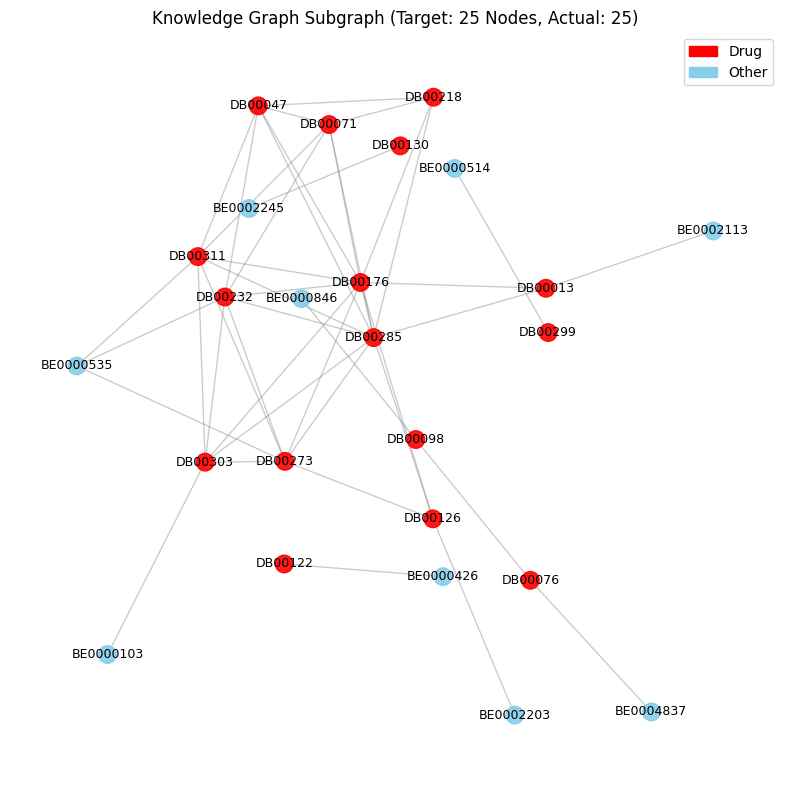


--- Visualizing KG Subgraph (Target: 50 Nodes) ---
Loaded: ./data/drugbank_entity_vocab.pkl
Loaded: ./data/drugbank_drug_vocab.pkl
Reading KG file: ./data/drugbank_train2id.txt
Subgraph: 49 nodes, 349 edges.


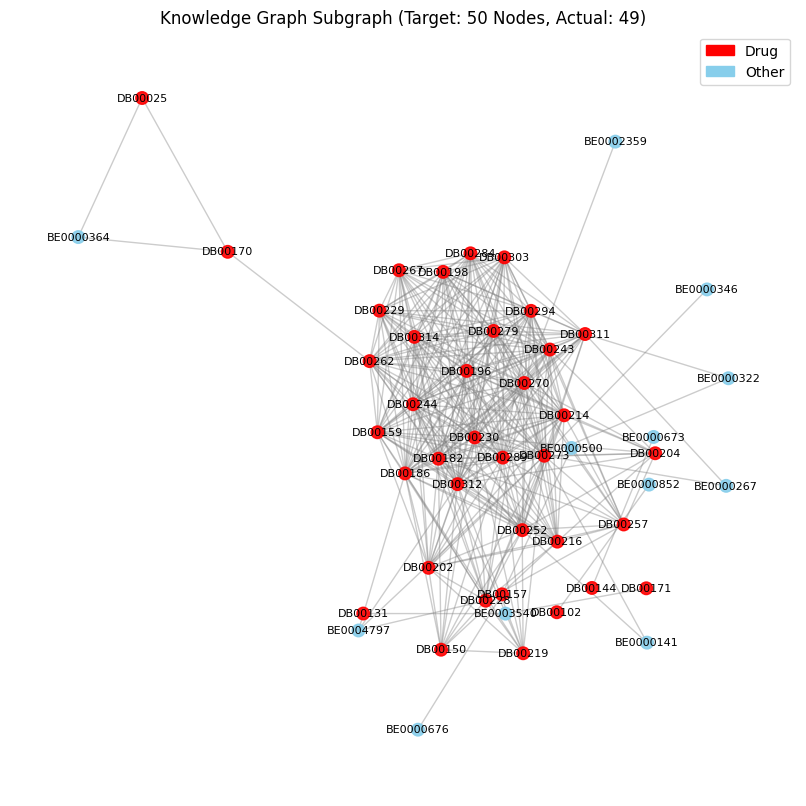


--- Visualizing KG Subgraph (Target: 75 Nodes) ---
Loaded: ./data/drugbank_entity_vocab.pkl
Loaded: ./data/drugbank_drug_vocab.pkl
Reading KG file: ./data/drugbank_train2id.txt
Subgraph: 75 nodes, 104 edges.


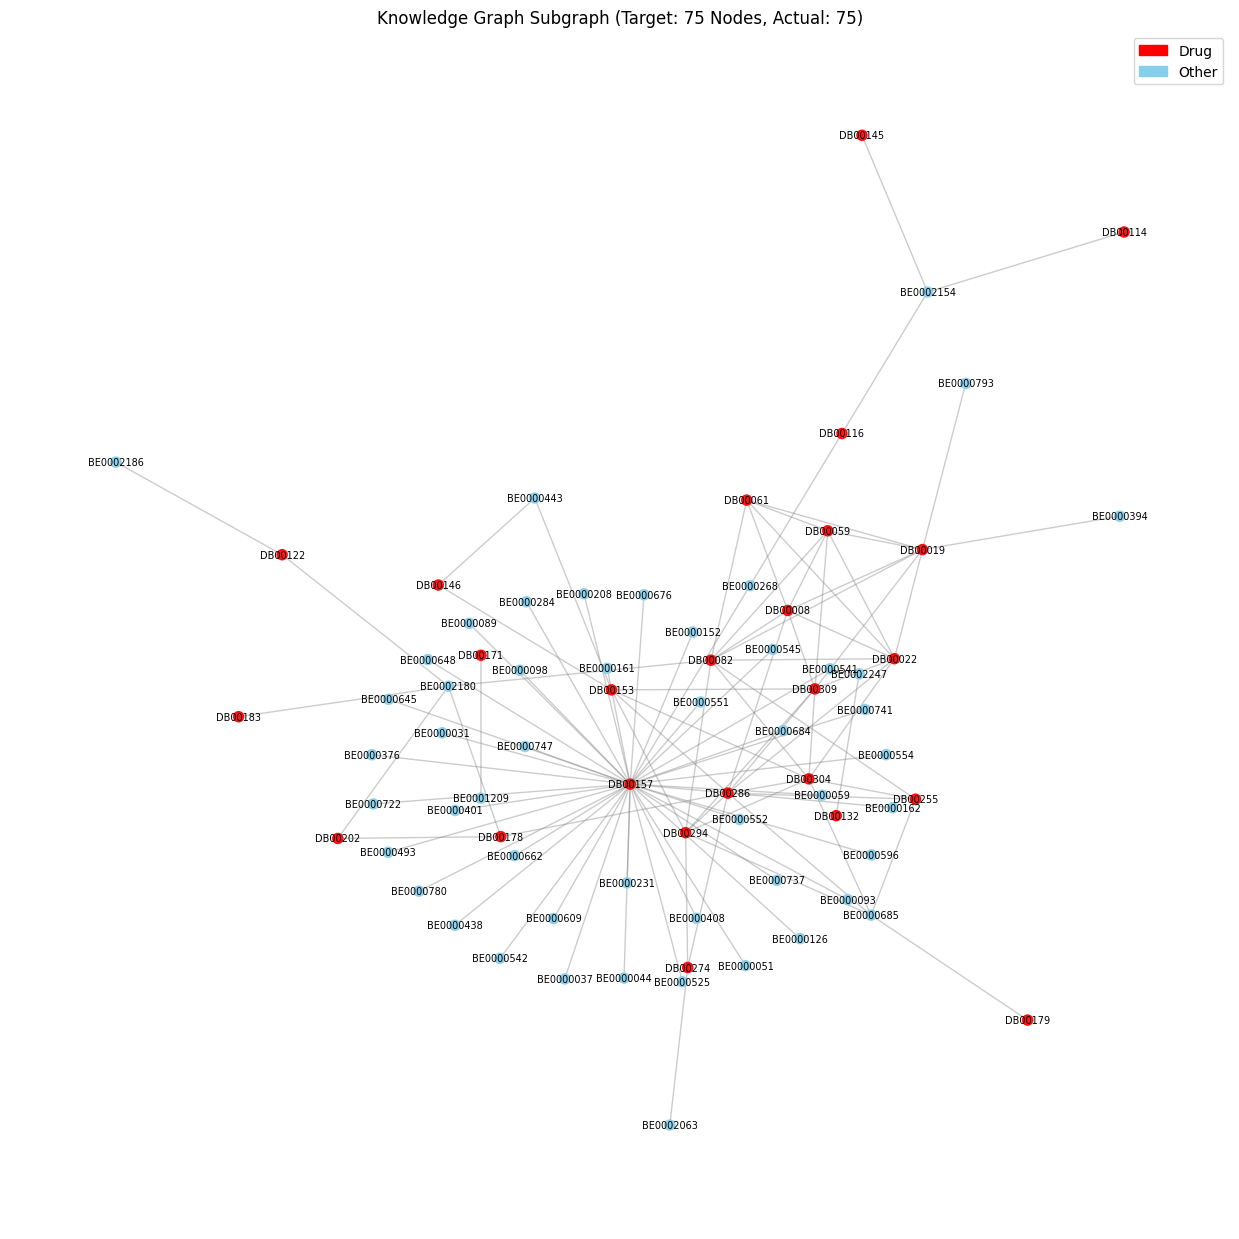


--- Visualizing KG Subgraph (Target: 100 Nodes) ---
Loaded: ./data/drugbank_entity_vocab.pkl
Loaded: ./data/drugbank_drug_vocab.pkl
Reading KG file: ./data/drugbank_train2id.txt
Subgraph: 98 nodes, 2022 edges.


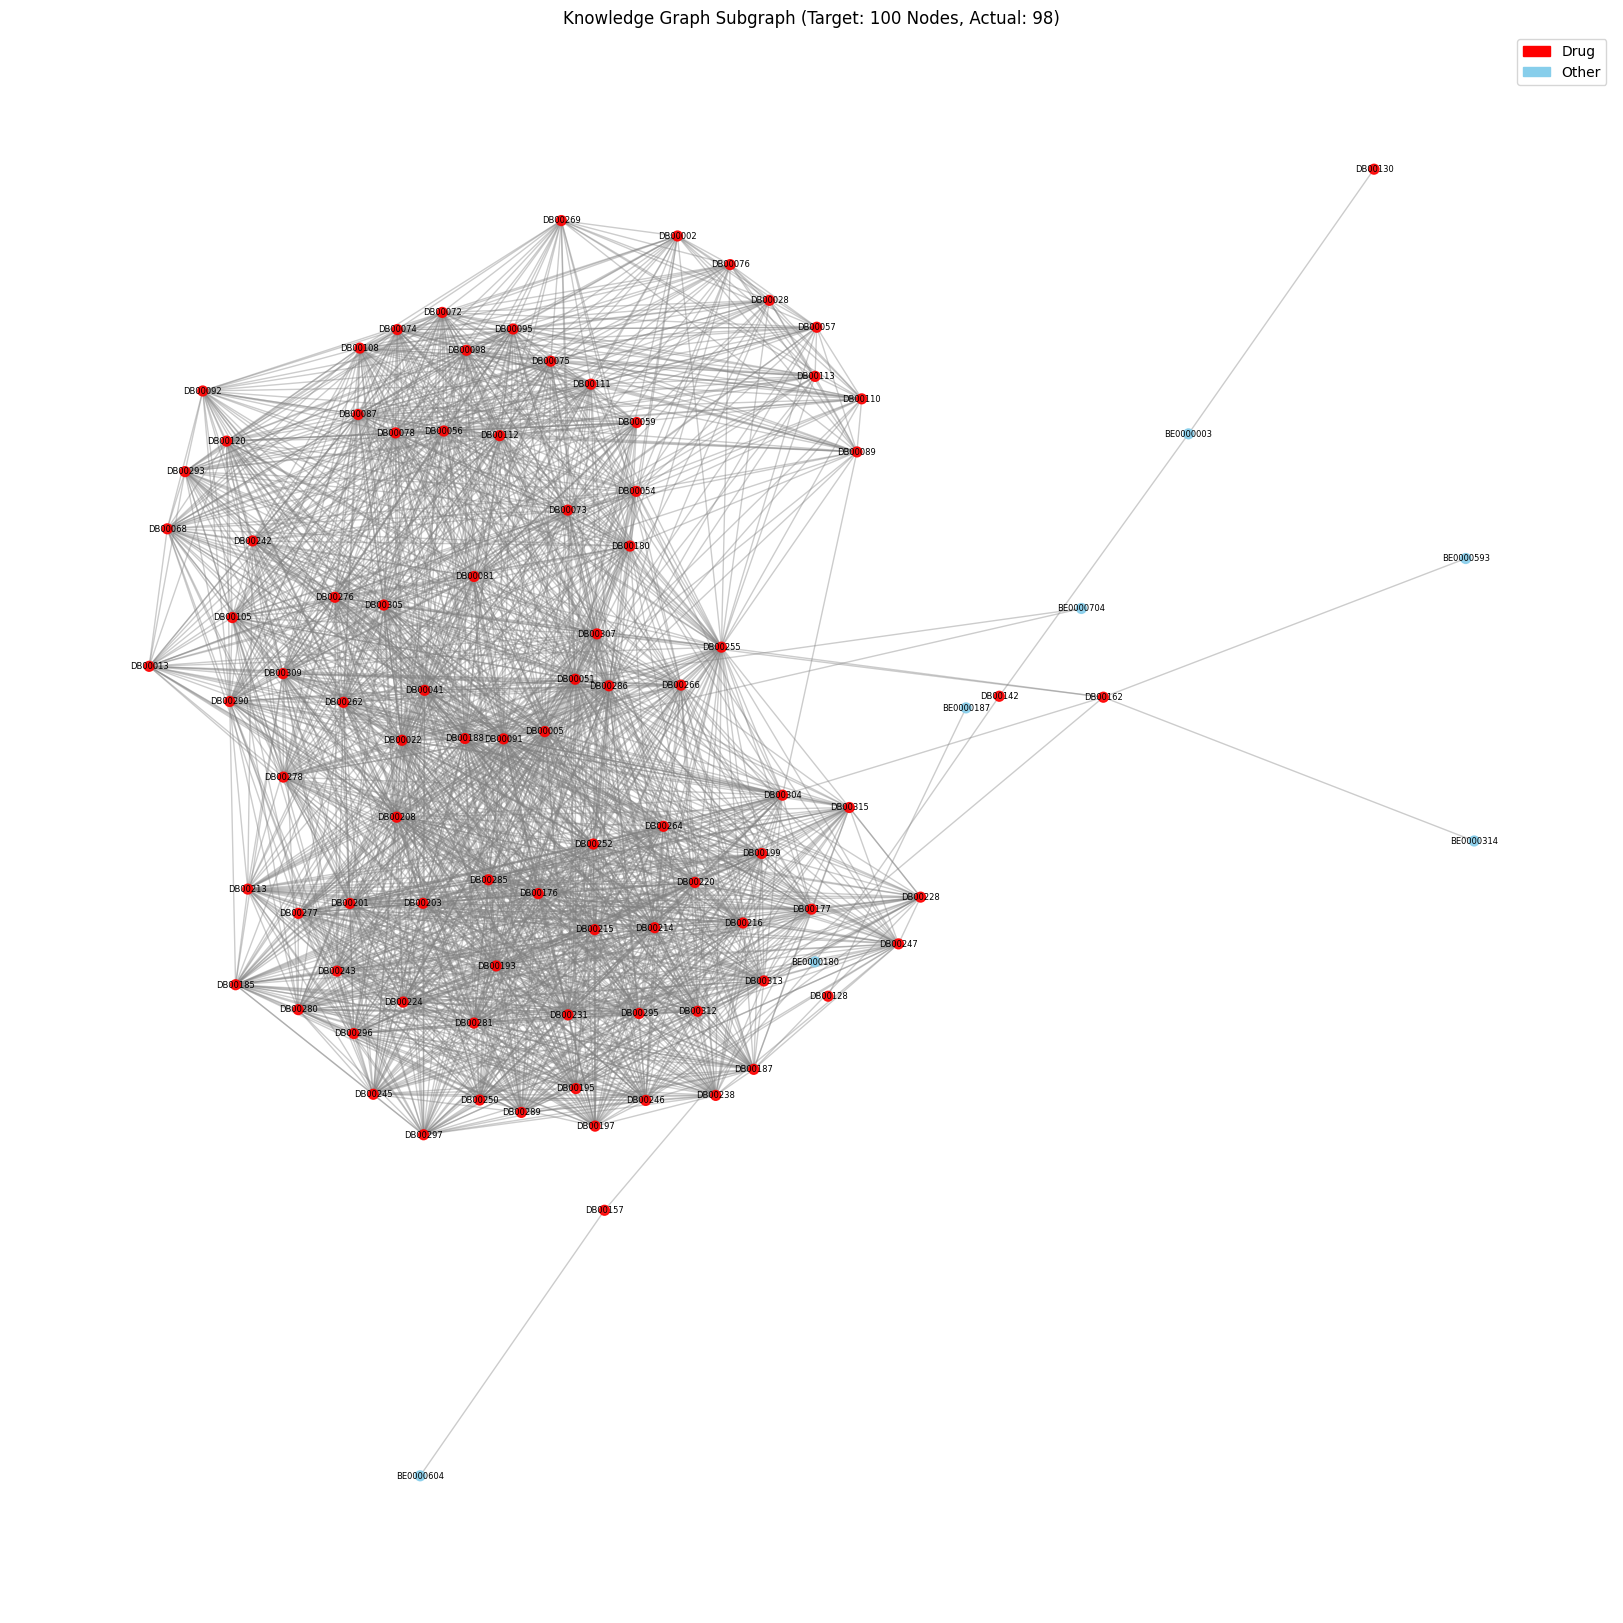


Cell 7: KG Visualization Complete.


In [18]:
# Cell 7: Enhanced KG Subgraph Visualization (Multiple Sizes)

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import numpy as np # Make sure numpy is imported
import os
import math # Needed for layout fallback calculation

# ========================= Helper Functions (Copied/Redefined) =========================
# (Assume pickle_load, format_filename defined in Cell 1 or globally)
def get_entity_type_map(entity_vocab_path, drug_vocab_path):
    entity_vocab = pickle_load(entity_vocab_path)
    drug_vocab = pickle_load(drug_vocab_path)
    if entity_vocab is None or drug_vocab is None: print("Error: Vocabs not found."); return None, None
    idx2entity = {v: k for k, v in entity_vocab.items()}
    entity_type_map = {}
    drug_ids = set(drug_vocab.keys())
    for idx, entity_id_str in idx2entity.items():
        entity_type_map[idx] = 'drug' if entity_id_str in drug_ids else 'other'
    return entity_type_map, idx2entity

def get_color_map(entity_type_map):
    colors = {'drug': 'red', 'other': 'skyblue'} # Simplified
    node_colors_list = []
    if entity_type_map:
         max_index = max(entity_type_map.keys()) if entity_type_map else -1
         node_colors_list = ['gray'] * (max_index + 1)
         for i in range(max_index + 1):
              if i in entity_type_map:
                   entity_type = entity_type_map[i]
                   node_colors_list[i] = colors.get(entity_type, 'gray')
    return node_colors_list


# ========================= KG Subgraph Visualization Function =========================
# (Keep visualize_kg_subgraph function exactly the same as the previous corrected version)
def visualize_kg_subgraph(kg_filepath, entity_vocab_path, drug_vocab_path, num_nodes_to_show=50, seed=42):
    """Visualizes a subgraph of the Knowledge Graph."""
    print(f"\n--- Visualizing KG Subgraph (Target: {num_nodes_to_show} Nodes) ---")
    random.seed(seed); np.random.seed(seed)

    entity_type_map, idx2entity = get_entity_type_map(entity_vocab_path, drug_vocab_path)
    node_colors_list = get_color_map(entity_type_map)

    if entity_type_map is None or not node_colors_list:
        print("Cannot visualize KG: Type map or color map failed.")
        return

    print(f"Reading KG file: {kg_filepath}")
    triples = []
    try:
        with open(kg_filepath, 'r', encoding='utf8') as f:
            next(f) # Skip count
            for line in f:
                parts = line.strip().split()
                if len(parts) == 3:
                    try:
                        h, t, r = map(int, parts)
                        if 0 <= h < len(node_colors_list) and 0 <= t < len(node_colors_list):
                             triples.append((h, t, r))
                    except ValueError: continue
    except FileNotFoundError: print(f"Error: KG file {kg_filepath} not found."); return
    except Exception as e: print(f"Error reading KG file {kg_filepath}: {e}"); return

    if not triples: print("No valid triples found/loaded for subgraph."); return

    # --- Create graph and select subset ---
    G = nx.Graph()
    nodes_in_subgraph = set()
    edges_added = 0
    available_nodes = list(entity_type_map.keys())
    if not available_nodes: print("No nodes available from entity map."); return

    # Ensure num_nodes_to_show is not greater than available nodes
    num_nodes_to_show = min(num_nodes_to_show, len(available_nodes))
    if num_nodes_to_show <= 0: print("Target node count is zero or less."); return

    # Start with a few random nodes, ensure start count <= target count
    start_node_count = min(10, num_nodes_to_show)
    start_nodes = random.sample(available_nodes, k=start_node_count)

    nodes_to_explore = list(start_nodes)
    nodes_in_subgraph.update(start_nodes)
    processed_nodes = set()
    while nodes_to_explore and len(nodes_in_subgraph) < num_nodes_to_show:
        current_node = nodes_to_explore.pop(0)
        if current_node in processed_nodes: continue
        processed_nodes.add(current_node)
        neighbors = set()
        for h, t, r in triples:
             neighbor_node = None
             if h == current_node and t not in nodes_in_subgraph: neighbor_node = t
             elif t == current_node and h not in nodes_in_subgraph: neighbor_node = h
             if neighbor_node is not None and 0 <= neighbor_node < len(node_colors_list):
                  neighbors.add(neighbor_node)

        new_neighbors = list(neighbors)
        random.shuffle(new_neighbors)
        for neighbor in new_neighbors:
            if len(nodes_in_subgraph) < num_nodes_to_show:
                 nodes_in_subgraph.add(neighbor)
                 if neighbor not in processed_nodes:
                     nodes_to_explore.append(neighbor)
            else: break

    # --- Add selected nodes and edges ---
    node_labels = {}
    nodes_added_to_nx = set()
    edges_in_subgraph = []
    for h, t, r in triples:
        if h in nodes_in_subgraph and t in nodes_in_subgraph:
            edges_in_subgraph.append((h, t))
            if h not in nodes_added_to_nx:
                 G.add_node(h); node_labels[h] = idx2entity.get(h, str(h))[:10]; nodes_added_to_nx.add(h)
            if t not in nodes_added_to_nx:
                 G.add_node(t); node_labels[t] = idx2entity.get(t, str(t))[:10]; nodes_added_to_nx.add(t)
    G.add_edges_from(edges_in_subgraph)

    print(f"Subgraph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges.")
    if not G.nodes: print("Subgraph is empty, cannot draw."); return

    # --- Plotting ---
    plt.figure(figsize=(max(8, G.number_of_nodes() / 6), max(8, G.number_of_nodes() / 6))) # Adjust size
    try: pos = nx.kamada_kawai_layout(G)
    except Exception as e:
        print(f"Layout failed: {e}. Falling back to spring layout.")
        pos = nx.spring_layout(G, seed=seed, k=0.5/math.sqrt(G.number_of_nodes()) if G.number_of_nodes()>0 else 0.5 )

    final_node_colors = [node_colors_list[node_idx] if 0 <= node_idx < len(node_colors_list) else 'purple' for node_idx in G.nodes()]
    node_size = max(50, 4000 / G.number_of_nodes()) if G.number_of_nodes() > 0 else 100
    font_size = max(5, 10 - G.number_of_nodes() // 20)

    nx.draw_networkx_edges(G, pos, alpha=0.4, edge_color='gray')
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=final_node_colors, alpha=0.9)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=font_size, font_color='black')

    # --- Legend ---
    legend_handles = []
    added_labels = set()
    unique_types_in_subgraph = set(entity_type_map[node] for node in G.nodes() if node in entity_type_map)
    color_dict = {'drug': 'red', 'other': 'skyblue'}
    for node_type in unique_types_in_subgraph:
         color = color_dict.get(node_type, 'gray'); label = node_type.capitalize()
         if label not in added_labels:
             legend_handles.append(patches.Patch(color=color, label=label)); added_labels.add(label)

    plt.title(f"Knowledge Graph Subgraph (Target: {num_nodes_to_show} Nodes, Actual: {G.number_of_nodes()})")
    if legend_handles: plt.legend(handles=legend_handles, loc='best', frameon=True)
    plt.axis('off'); plt.tight_layout(); plt.show()


# ========================= Execution for Multiple Sizes =========================
# Define file paths
# Assume PROCESSED_DATA_DIR and DATASET_NAME are globally defined
kg_filepath = format_filename(PROCESSED_DATA_DIR, KG_FILE_TEMPLATE, dataset=DATASET_NAME)
entity_vocab_path = format_filename(PROCESSED_DATA_DIR, ENTITY_VOCAB_TEMPLATE, dataset=DATASET_NAME)
drug_vocab_path = format_filename(PROCESSED_DATA_DIR, DRUG_VOCAB_TEMPLATE, dataset=DATASET_NAME)

if all(os.path.exists(p) for p in [kg_filepath, entity_vocab_path, drug_vocab_path]):
    print("\nGenerating KG Subgraph Visualizations for different sizes...")

    # Define the target sizes and seeds
    target_sizes = [25, 50, 75, 100]
    seeds = [42, 43, 44, 45, 46] # Use different seeds

    # Loop through the sizes and generate plots
    for i, size in enumerate(target_sizes):
        visualize_kg_subgraph(
            kg_filepath,
            entity_vocab_path,
            drug_vocab_path,
            num_nodes_to_show=size,
            seed=seeds[i] # Use corresponding seed
        )
else:
    print("Error: Missing required files for KG visualization. Ensure previous cells ran successfully.")
    print(f"Checked paths:\n - KG: {kg_filepath}\n - Entity Vocab: {entity_vocab_path}\n - Drug Vocab: {drug_vocab_path}")

print("\nCell 7: KG Visualization Complete.")

Loaded: ./data/drugbank_drug_vocab.pkl

Generating 3 KGNN Neighborhood Visualizations...
Selected indices for visualization: [167, 203, 177]

--- Visualizing KGNN 2-Hop Neighborhood for Node 167 ---
Neighborhood for 167: {0: 1, 1: 16, 2: 123}
Loaded: ./data/drugbank_entity_vocab.pkl
Loaded: ./data/drugbank_drug_vocab.pkl
Adding aggregation edges...
Added 235 aggregation edges.


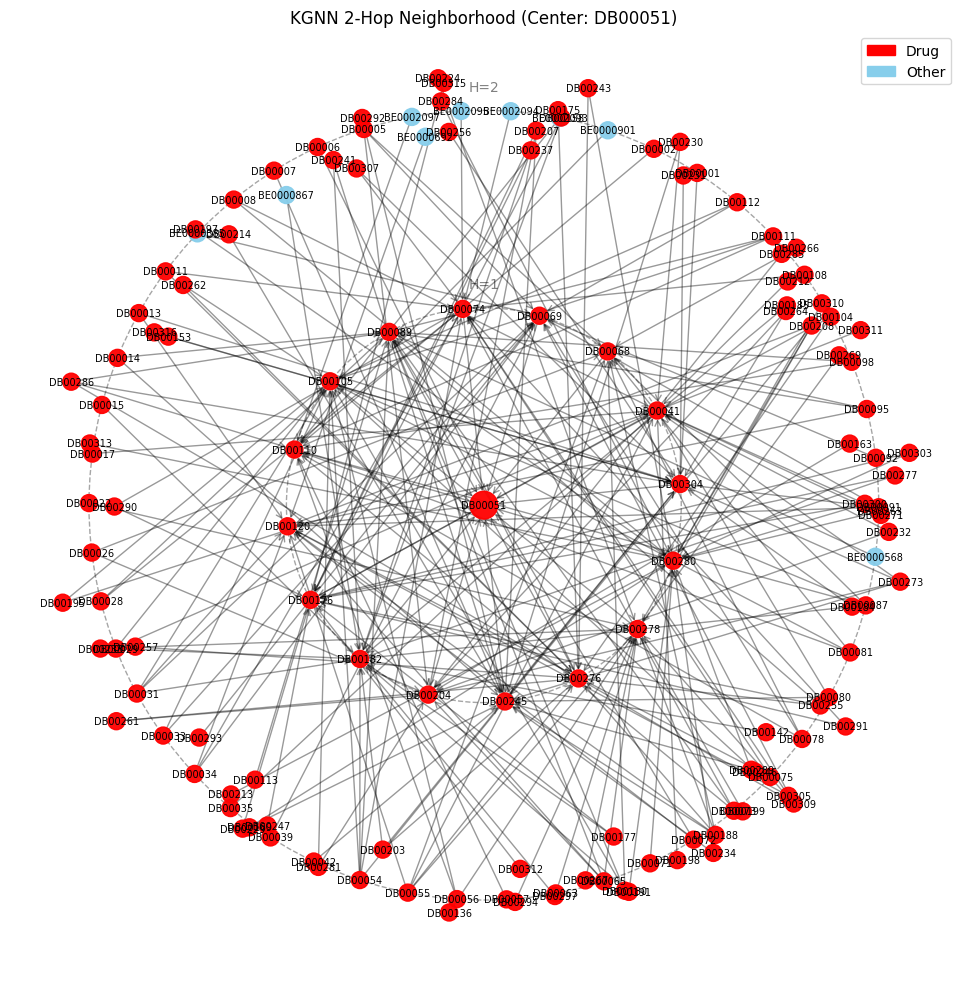


--- Visualizing KGNN 2-Hop Neighborhood for Node 203 ---
Neighborhood for 203: {0: 1, 1: 12, 2: 106}
Loaded: ./data/drugbank_entity_vocab.pkl
Loaded: ./data/drugbank_drug_vocab.pkl
Adding aggregation edges...
Added 173 aggregation edges.


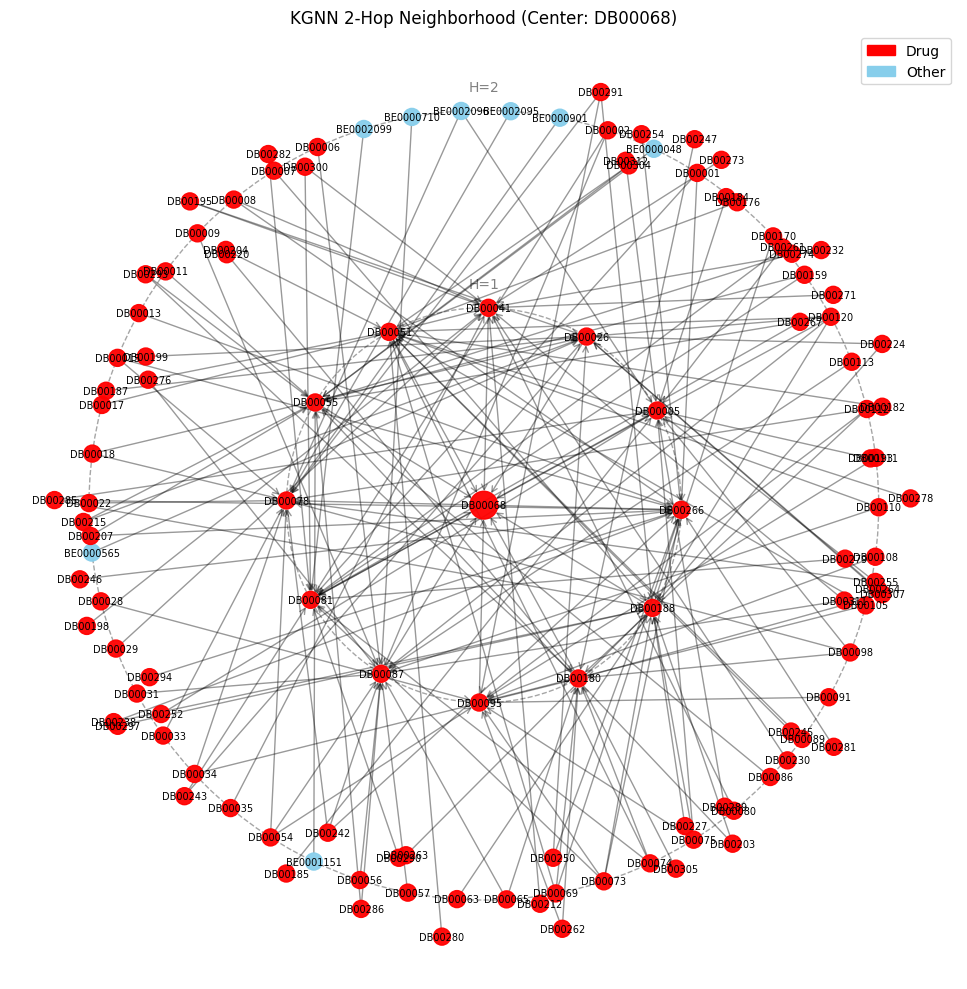


--- Visualizing KGNN 2-Hop Neighborhood for Node 177 ---
Neighborhood for 177: {0: 1, 1: 15, 2: 122}
Loaded: ./data/drugbank_entity_vocab.pkl
Loaded: ./data/drugbank_drug_vocab.pkl
Adding aggregation edges...
Added 199 aggregation edges.


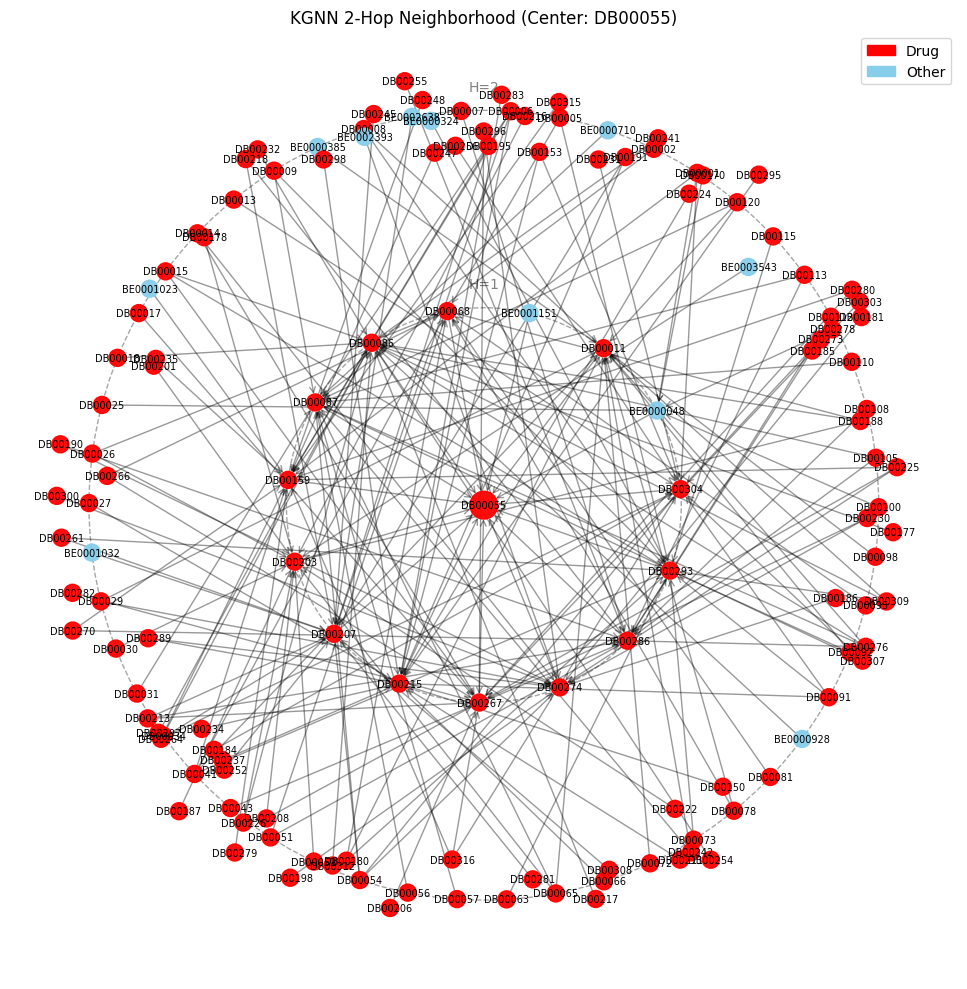


Cell 8: KGNN Visualization Complete.


In [15]:
# Cell 8: Enhanced KGNN Neighborhood Visualization

import math
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import numpy as np
import os

# ========================= Helper Functions (Copied/Redefined) =========================
# (Assume pickle_load, format_filename, get_entity_type_map, get_color_map defined correctly)
def pickle_load(filename: str):
    try:
        with open(filename, 'rb') as f: obj = pickle.load(f)
        print(f'Loaded: {filename}'); return obj
    except Exception as e: print(f'Error loading {filename}: {e}'); return None

def format_filename(_dir: str, filename_template: str, **kwargs):
    if 'DATASET_NAME' not in globals(): global DATASET_NAME; DATASET_NAME = 'drugbank'
    kwargs.setdefault('dataset', DATASET_NAME)
    return os.path.join(_dir, filename_template.format(**kwargs))

def get_entity_type_map(entity_vocab_path, drug_vocab_path):
    entity_vocab = pickle_load(entity_vocab_path); drug_vocab = pickle_load(drug_vocab_path)
    if entity_vocab is None or drug_vocab is None: return None, None
    idx2entity = {v: k for k, v in entity_vocab.items()}; entity_type_map = {}
    drug_ids = set(drug_vocab.keys())
    for idx, entity_id_str in idx2entity.items():
        entity_type_map[idx] = 'drug' if entity_id_str in drug_ids else 'other'
    return entity_type_map, idx2entity

def get_color_map(entity_type_map):
    colors = {'drug': 'red', 'other': 'skyblue'}; node_colors_list = []
    if entity_type_map:
         max_index = max(entity_type_map.keys()) if entity_type_map else -1
         node_colors_list = ['gray'] * (max_index + 1)
         for i in range(max_index + 1):
              if i in entity_type_map: node_colors_list[i] = colors.get(entity_type_map[i], 'gray')
    return node_colors_list

# ========================= KGNN Neighborhood Extraction =========================
# (Keep get_kgnn_neighborhood function the same)
def get_kgnn_neighborhood(center_node_idx, adj_entity, n_depth=2):
    if adj_entity is None: print("Error: Adj matrix missing."); return None, None
    if not (0 <= center_node_idx < adj_entity.shape[0]): print(f"Error: Index {center_node_idx} out of bounds."); return None, None
    neighbors_by_hop = {0: {center_node_idx}}; all_neighbors_found = {center_node_idx}
    current_hop_nodes = {center_node_idx}
    for h in range(1, n_depth + 1):
        next_hop_nodes = set()
        if not current_hop_nodes: break
        for node_idx in current_hop_nodes:
             if 0 <= node_idx < adj_entity.shape[0]: next_hop_nodes.update(set(adj_entity[node_idx]))
        new_neighbors = next_hop_nodes - all_neighbors_found
        if not new_neighbors: break
        neighbors_by_hop[h] = new_neighbors; all_neighbors_found.update(new_neighbors)
        current_hop_nodes = new_neighbors
    hops_to_remove = [h for h, nodes in neighbors_by_hop.items() if not nodes and h > 0]
    for h in hops_to_remove: del neighbors_by_hop[h]
    print(f"Neighborhood for {center_node_idx}: { {h: len(nodes) for h, nodes in neighbors_by_hop.items()} }")
    return neighbors_by_hop, all_neighbors_found

# ========================= KGNN Visualization Function =========================
# (Keep visualize_kgnn_neighborhood function the same)
def visualize_kgnn_neighborhood(center_node_idx, adj_entity, entity_vocab_path, drug_vocab_path, n_depth=2, seed=42):
    """Visualizes the H-hop neighborhood for KGNN."""
    print(f"\n--- Visualizing KGNN {n_depth}-Hop Neighborhood for Node {center_node_idx} ---")
    random.seed(seed); np.random.seed(seed)
    neighbors_by_hop, all_neighbors_found = get_kgnn_neighborhood(center_node_idx, adj_entity, n_depth)
    if neighbors_by_hop is None or not all_neighbors_found: print("Failed to get neighborhood."); return
    entity_type_map, idx2entity = get_entity_type_map(entity_vocab_path, drug_vocab_path)
    node_colors_list = get_color_map(entity_type_map)
    if entity_type_map is None or not node_colors_list: print("Cannot visualize: Map/color failed."); return

    G = nx.DiGraph(); pos = {}; node_colors_in_graph = {}; node_labels = {}
    center_pos = (0, 0); radii = {h: h * 1.0 for h in range(n_depth + 1)}
    max_radius = radii.get(max(neighbors_by_hop.keys()) if neighbors_by_hop else 0, 1.0)
    max_nodes_per_hop_for_layout = 50
    if not (0 <= center_node_idx < len(node_colors_list)): print(f"Error: center_idx {center_node_idx} invalid."); return
    G.add_node(center_node_idx); pos[center_node_idx] = center_pos
    node_colors_in_graph[center_node_idx] = node_colors_list[center_node_idx]
    node_labels[center_node_idx] = idx2entity.get(center_node_idx, str(center_node_idx))[:10]

    for hop, nodes in neighbors_by_hop.items():
        if hop == 0: continue
        radius = radii.get(hop, hop * 1.0)
        num_nodes_at_hop = len(nodes); display_nodes_count = min(num_nodes_at_hop, max_nodes_per_hop_for_layout)
        if display_nodes_count == 0: continue
        angle_step = 2 * math.pi / display_nodes_count if display_nodes_count > 0 else 0
        sorted_nodes = sorted(list(nodes)); nodes_for_layout = sorted_nodes[:display_nodes_count]
        for i, node_idx in enumerate(sorted_nodes):
             if not (0 <= node_idx < len(node_colors_list)): continue
             if i < display_nodes_count: angle = i * angle_step + (hop*0.5); x, y = radius*math.cos(angle), radius*math.sin(angle)
             else: angle = random.uniform(0, 2*math.pi); r_offset=random.uniform(0.9,1.1); x,y = radius*r_offset*math.cos(angle), radius*r_offset*math.sin(angle)
             pos[node_idx] = (x, y)
             if node_idx not in G: G.add_node(node_idx)
             node_colors_in_graph[node_idx] = node_colors_list[node_idx]
             node_labels[node_idx] = idx2entity.get(node_idx, str(node_idx))[:10]

    print("Adding aggregation edges..."); edges_added = 0
    max_hops_present = max(neighbors_by_hop.keys()) if neighbors_by_hop else 0
    for hop in range(max_hops_present, 0, -1):
         if hop not in neighbors_by_hop or (hop-1) not in neighbors_by_hop: continue
         current_hop_nodes = neighbors_by_hop[hop]; prev_hop_nodes = neighbors_by_hop[hop-1]
         for u in current_hop_nodes:
             if not (0 <= u < adj_entity.shape[0]): continue
             for v in prev_hop_nodes:
                 if not (0 <= v < adj_entity.shape[0]): continue
                 if u in adj_entity[v]:
                     if u in G and v in G: G.add_edge(u, v); edges_added += 1
    print(f"Added {edges_added} aggregation edges.")
    if not G.nodes: print("Graph is empty."); return

    plt.figure(figsize=(10, 10)); ax = plt.gca()
    for hop in range(1, max_hops_present + 1):
        radius = radii.get(hop, hop * 1.0)
        circle = patches.Circle(center_pos, radius, fill=False, linestyle='--', color='gray', alpha=0.7, zorder=1)
        ax.add_patch(circle); plt.text(0, radius + 0.1, f'H={hop}', ha='center', color='gray', zorder=1)
    node_color_list_final = [node_colors_in_graph.get(node, 'gray') for node in G.nodes()]
    node_size_list = [400 if node == center_node_idx else 150 for node in G.nodes()]
    nx.draw_networkx_edges(G, pos, alpha=0.4, edge_color='black', node_size=node_size_list, arrows=True, arrowstyle='->', arrowsize=10)
    nx.draw_networkx_nodes(G, pos, node_size=node_size_list, node_color=node_color_list_final, alpha=0.95)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=7)
    legend_handles = []; added_labels = set()
    unique_types_in_graph = set(entity_type_map[node] for node in G.nodes() if node in entity_type_map)
    color_dict = {'drug': 'red', 'other': 'skyblue'}
    for node_type in unique_types_in_graph:
         color = color_dict.get(node_type, 'gray'); label = node_type.capitalize()
         if label not in added_labels: legend_handles.append(patches.Patch(color=color, label=label)); added_labels.add(label)
    center_node_label = idx2entity.get(center_node_idx, f"Index {center_node_idx}")
    plt.title(f"KGNN {n_depth}-Hop Neighborhood (Center: {center_node_label})")
    if legend_handles: plt.legend(handles=legend_handles, loc='best', frameon=True)
    plot_radius = max_radius * 1.2; ax.set_xlim(-plot_radius, plot_radius); ax.set_ylim(-plot_radius, plot_radius)
    ax.set_aspect('equal', adjustable='box'); plt.axis('off'); plt.tight_layout(); plt.show()


# ========================= Execution for Multiple Indices =========================
entity_vocab_path = format_filename(PROCESSED_DATA_DIR, ENTITY_VOCAB_TEMPLATE, dataset=DATASET_NAME)
drug_vocab_path = format_filename(PROCESSED_DATA_DIR, DRUG_VOCAB_TEMPLATE, dataset=DATASET_NAME)
adj_entity_path = format_filename(PROCESSED_DATA_DIR, ADJ_ENTITY_TEMPLATE, dataset=DATASET_NAME)

adj_entity = np.load(adj_entity_path) if os.path.exists(adj_entity_path) else None
drug_vocab = pickle_load(drug_vocab_path) # Load drug vocab for coloring/labeling

if adj_entity is not None and drug_vocab is not None:
    num_examples_to_plot = 3 # How many neighborhood examples to generate
    print(f"\nGenerating {num_examples_to_plot} KGNN Neighborhood Visualizations...")

    # Get a list of valid indices (can be all nodes or just drugs)
    # Option 1: Use only valid drug indices
    valid_indices = [idx for idx in drug_vocab.values() if 0 <= idx < adj_entity.shape[0]]
    if not valid_indices: # Fallback if no valid drug indices found
         print("Warning: No valid drug indices found in adj matrix bounds. Using any valid index.")
         valid_indices = [idx for idx in range(adj_entity.shape[0])]

    if valid_indices:
        # Select random indices from the valid list
        # Ensure we don't request more examples than available valid indices
        num_to_sample = min(num_examples_to_plot, len(valid_indices))
        indices_to_visualize = random.sample(valid_indices, k=num_to_sample)

        print(f"Selected indices for visualization: {indices_to_visualize}")

        # Loop and visualize
        for i, center_node_idx in enumerate(indices_to_visualize):
             visualize_kgnn_neighborhood(
                 center_node_idx,
                 adj_entity,
                 entity_vocab_path,
                 drug_vocab_path,
                 n_depth=2,
                 seed=42+i # Use different seed for slight layout variation
             )
    else:
         print("Error: No valid indices available to select for visualization.")

else:
    print("Error: Could not load adjacency matrix or drug vocabulary for KGNN visualization.")

print("\nCell 8: KGNN Visualization Complete.")

# Cell 9: Dataset Description

## Dataset: DrugBank

**Source:** [https://go.drugbank.com/](https://go.drugbank.com/) (Specifically, the `full database.xml` file)

**Version Used:** (Ideally, note the version downloaded, e.g., 5.1.x - if unknown, state "Version available on [Date Downloaded]")

**Description:**

DrugBank is a comprehensive, freely accessible online database containing detailed information about drugs and drug targets. It is widely used in bioinformatics, cheminformatics, pharmacology, and pharmaceutical research. The database integrates extensive data covering:

1.  **Drug Information:** Chemical structures, names (generic, brand, synonyms), descriptions, pharmacodynamics, pharmacokinetics (absorption, distribution, metabolism, excretion - ADME), mechanisms of action, indications, contraindications, toxicity profiles, and more.
2.  **Target Information:** Detailed information on the biological targets of drugs, including proteins (e.g., enzymes, transporters, carriers, receptors), nucleic acids. This includes sequences, structures, pathways, and functions associated with these targets.
3.  **Interactions:**
    *   **Drug-Target Interactions:** Specifies the known interactions between drugs and their biological targets, often including the specific action (e.g., inhibitor, agonist, antagonist).
    *   **Drug-Enzyme Interactions:** Details how drugs interact with metabolic enzymes (e.g., Cytochrome P450 system), affecting drug metabolism.
    *   **Drug-Transporter/Carrier Interactions:** Information on how drugs interact with membrane transporters and carriers, influencing their distribution and elimination.
    *   **Drug-Drug Interactions (DDIs):** Clinically relevant interactions known to occur between pairs of drugs, often accompanied by descriptions of the potential effects.
4.  **Other Data:** Includes pathways involved, food interactions, patent information, pricing, experimental and predicted properties, and external database links.

**Format:** The comprehensive data is provided in XML format (`full database.xml`), featuring a nested structure that reflects the complex relationships between different data types.

**Relevance to this Project:**

In this project, the DrugBank XML file served as the primary source for constructing the knowledge graph. We specifically extracted:
*   Drug entities (nodes).
*   Protein entities associated with drugs (targets, enzymes, etc. - simplified as 'other' nodes).
*   Relationships between drugs and these proteins (edges representing 'targets', 'enzyme_interaction', etc.).
*   Known drug-drug interactions, which formed the basis for the `interacts_with` relation in the KG and the positive training examples for the DDI prediction task.

The richness of DrugBank allows for the creation of a multi-relational graph structure that captures diverse biological contexts, making it suitable for training Knowledge Graph Neural Networks like the KGNN model used here.

**Reference:** Wishart, D. S., et al. (2018). DrugBank 5.0: a major update to the DrugBank database for 2018. *Nucleic acids research*, 46(D1), D1074-D1082.